In [ ]:
from google.colab import drive
import pandas as pd
import torch
import re
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
#from torchtext.data.utils import get_tokenizer
#from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import torch.nn.functional as F
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from statsmodels.stats.contingency_tables import mcnemar

#import datasets
#from datasets import Dataset,DatasetDict,Features,Value,ClassLabel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#drive.mount('/content/drive')
DATA_DIR = "../../data/reddit/"
DATA_DIR_DICT = DATA_DIR + "Reddit_Info/"
RESULTS_DIR = "../../results/"

Mounted at /content/drive


In [3]:
# Parameters
SEED = 0
BATCH_SIZE = 48
WORD_EMBED_DIM = 256
HID_EMBED_DIM = 256
DROPOUT = 0.5
CLIP = 0.25
BPTT = 50
EPOCHS = 30
torch.manual_seed(SEED)

In [4]:
column_names = ['text', 'label', 'rater']
red_train = pd.read_csv(DATA_DIR + 'RED_Training.tsv', sep='\t', header=None, names=column_names)
red_val = pd.read_csv(DATA_DIR + 'RED_Validation.tsv', sep='\t', header=None, names=column_names)
red_test= pd.read_csv(DATA_DIR + 'RED_Test.tsv', sep='\t', header=None, names=column_names)

In [5]:
# Remove Neutral for BERT and Twitter Analysis

red_train = red_train[~red_train['label'].astype(str).str.contains('27')]
red_val = red_val[~red_val['label'].astype(str).str.contains('27')]
red_test = red_test[~red_test['label'].astype(str).str.contains('27')]

print(len(red_train))
print(len(red_val))
print(len(red_test))

29191
3660
3640


In [6]:
with open(DATA_DIR_DICT + 'sentiment_dict.json', "r") as file:
    sentiment_mapping = json.load(file)

with open(DATA_DIR_DICT +"ekman_mapping_updated.json", "r") as file:
    ekman_mapping = json.load(file)

# Print to check structure
print("Sentiment Mapping:", sentiment_mapping)
print("\nEkman Mapping:", ekman_mapping)

Sentiment Mapping: {'positive': ['amusement', 'excitement', 'joy', 'love', 'desire', 'optimism', 'caring', 'pride', 'admiration', 'gratitude', 'relief', 'approval'], 'negative': ['fear', 'nervousness', 'remorse', 'embarrassment', 'disappointment', 'sadness', 'grief', 'disgust', 'anger', 'annoyance', 'disapproval'], 'ambiguous': ['realization', 'surprise', 'curiosity', 'confusion']}

Ekman Mapping: {'anger': ['anger', 'annoyance', 'disapproval', 'disgust'], 'fear': ['fear', 'nervousness'], 'joy': ['joy', 'amusement', 'approval', 'excitement', 'gratitude', 'optimism', 'relief', 'pride'], 'love': ['love', 'admiration', 'desire', 'caring'], 'sadness': ['sadness', 'disappointment', 'embarrassment', 'grief', 'remorse'], 'surprise': ['surprise', 'realization', 'confusion', 'curiosity']}


In [7]:
# one-hot-coding reddit labels

def labels_to_one_hot(label_list, num_classes):
    one_hot = np.zeros(num_classes, dtype=np.float32)
    for label in label_list:
        one_hot[label] = 1
    return one_hot

red_train["label"] = red_train["label"].apply(lambda x: [int(i) for i in str(x).split(",")])
red_val["label"] = red_val["label"].apply(lambda x: [int(i) for i in str(x).split(",")])
red_test["label"] = red_test["label"].apply(lambda x: [int(i) for i in str(x).split(",")])
num_labels = max(max(l) for l in red_train["label"]) + 1

red_train["one_hot_label"] = red_train["label"].apply(lambda x: labels_to_one_hot(x, num_labels))
red_val["one_hot_label"] = red_val["label"].apply(lambda x: labels_to_one_hot(x, num_labels))
red_test["one_hot_label"] = red_test["label"].apply(lambda x: labels_to_one_hot(x, num_labels))

In [8]:
# bin reddit emotions into same labels as twitter

emotion_to_six = {}
for six_emotion, subcategories in ekman_mapping.items():
    for emotion in subcategories:
        emotion_to_six[emotion] = six_emotion

# Print mapping
print("28-labels to 6-label mapping:", emotion_to_six)

28-labels to 6-label mapping: {'anger': 'anger', 'annoyance': 'anger', 'disapproval': 'anger', 'disgust': 'anger', 'fear': 'fear', 'nervousness': 'fear', 'joy': 'joy', 'amusement': 'joy', 'approval': 'joy', 'excitement': 'joy', 'gratitude': 'joy', 'optimism': 'joy', 'relief': 'joy', 'pride': 'joy', 'love': 'love', 'admiration': 'love', 'desire': 'love', 'caring': 'love', 'sadness': 'sadness', 'disappointment': 'sadness', 'embarrassment': 'sadness', 'grief': 'sadness', 'remorse': 'sadness', 'surprise': 'surprise', 'realization': 'surprise', 'confusion': 'surprise', 'curiosity': 'surprise'}


In [9]:
#Label Preprocessing

emotion_labels = [
    "admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion", "curiosity",
    "desire", "disappointment", "disapproval", "disgust", "embarrassment", "excitement", "fear",
    "gratitude", "grief", "joy", "love", "nervousness", "optimism", "pride", "realization", "relief",
    "remorse", "sadness", "surprise"
]


def map_labels_to_six(label_list, emotion_to_six):
    """
    Converts a multi-label emotion list into a single 6-emotion label.
    Uses the first mapped emotion found in the list.

    """
    string_labels = []
    for label in label_list:
        string_labels.append(emotion_labels[label])

    mapped_labels = [emotion_to_six[emotion] for emotion in string_labels if emotion in emotion_to_six]

    # Assign the first matching label, or default to "neutral" if none exist
    return mapped_labels[0] if mapped_labels else "neutral"

# Apply mapping to dataset
red_train["six_label"] = red_train["label"].apply(lambda labels: map_labels_to_six(labels, emotion_to_six))
red_val["six_label"] = red_val["label"].apply(lambda labels: map_labels_to_six(labels, emotion_to_six))
red_test["six_label"] = red_test["label"].apply(lambda labels: map_labels_to_six(labels, emotion_to_six))


In [10]:
# Create a LabelEncoder object
six_label_encoder = LabelEncoder()
six_label_encoder.fit(red_train['six_label'])

# Transform the 'six_label' column to numerical values
red_train['six_label_num'] = six_label_encoder.transform(red_train['six_label'])
red_val['six_label_num'] = six_label_encoder.transform(red_val['six_label'])
red_test['six_label_num'] = six_label_encoder.transform(red_test['six_label'])

In [11]:
label_names = {"sadness": 0, "joy": 1, "love": 2, "anger": 3, "fear": 4, "surprise": 5}

red_train["six_label_num_new"] = red_train["six_label"].map(label_names).astype(int)
red_val["six_label_num"] = red_val["six_label"].map(label_names).astype(int)
red_test["six_label_num"] = red_test["six_label"].map(label_names).astype(int)

# Convert label column to list
train_labels = red_train["six_label_num_new"].tolist()
val_labels = red_val["six_label_num"].tolist()
test_labels = red_test["six_label_num"].tolist()


In [12]:
red_train.head(10)

,text,label,rater,one_hot_label,six_label,six_label_num,six_label_num_new
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",anger,0,3
3,To make her feel threatened,[14],ed7ypvh,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",fear,1,4
4,Dirty Southern Wankers,[3],ed0bdzj,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",anger,0,3
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,[26],edvnz26,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",surprise,5,5
6,Yes I heard abt the f bombs! That has to be wh...,[15],ee3b6wu,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",joy,2,1
7,We need more boards and to create a bit more s...,"[8, 20]",ef4qmod,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",love,3,2
8,Damn youtube and outrage drama is super lucrat...,[0],ed8wbdn,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",love,3,2
10,Demographics? I don’t know anybody under 35 wh...,[6],eel6g5h,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",surprise,5,5
11,"Aww... she'll probably come around eventually,...","[1, 4]",edex4ki,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",joy,2,1
13,R/sleeptrain Might be time for some sleep trai...,[5],efh7xnk,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",love,3,2


In [13]:
#Text preprocessing

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S*|\S*\.com\S*|\S*www\S*", " ", text) # eliminate urls
    text = re.sub(r"\s@\S+", " ", text) # eliminate @mentions
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = text.strip()
    text = text.split()
    return [w for w in text if len(w) > 2]


def build_vocab(dataset):
    word_list = [word for text in dataset['text'] for word in preprocess_text(text)]
    word_counts = Counter(word_list)
    vocab = {word: i + 1 for i, (word, _) in enumerate(word_counts.most_common())}
    vocab["<unk>"] = 0  # Unknown words
    return vocab

def text_to_sequence(text):
    return [red_train_vocab[word] for word in preprocess_text(text) if word in red_train_vocab]

In [14]:
red_vocab = build_vocab(red_train)
red_val_vocab = build_vocab(red_val)
red_test_vocab = build_vocab(red_test)

In [15]:
print(red_train.dtypes)  # Check column data types
print(red_train["text"].apply(type).value_counts())  # Count different data types in "text"

text                 object
label                object
rater                object
one_hot_label        object
six_label            object
six_label_num         int64
six_label_num_new     int64
dtype: object
text
<class 'str'>    29191
Name: count, dtype: int64


In [16]:
all_labels = [label for sublist in red_train["label"] for label in sublist]
label_counts = Counter(all_labels)
label_df = pd.DataFrame(label_counts.items(), columns=["Label", "Count"]).sort_values("Label")

six_label_counts = Counter(red_train["six_label_num"])
six_label_df = pd.DataFrame(six_label_counts.items(), columns=["Label", "Count"]).sort_values("Label")

six_list = list(six_label_encoder.classes_)

<ipython-input-17-1e2d57fb684e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_labels, y=label_df["Count"], palette="Reds")


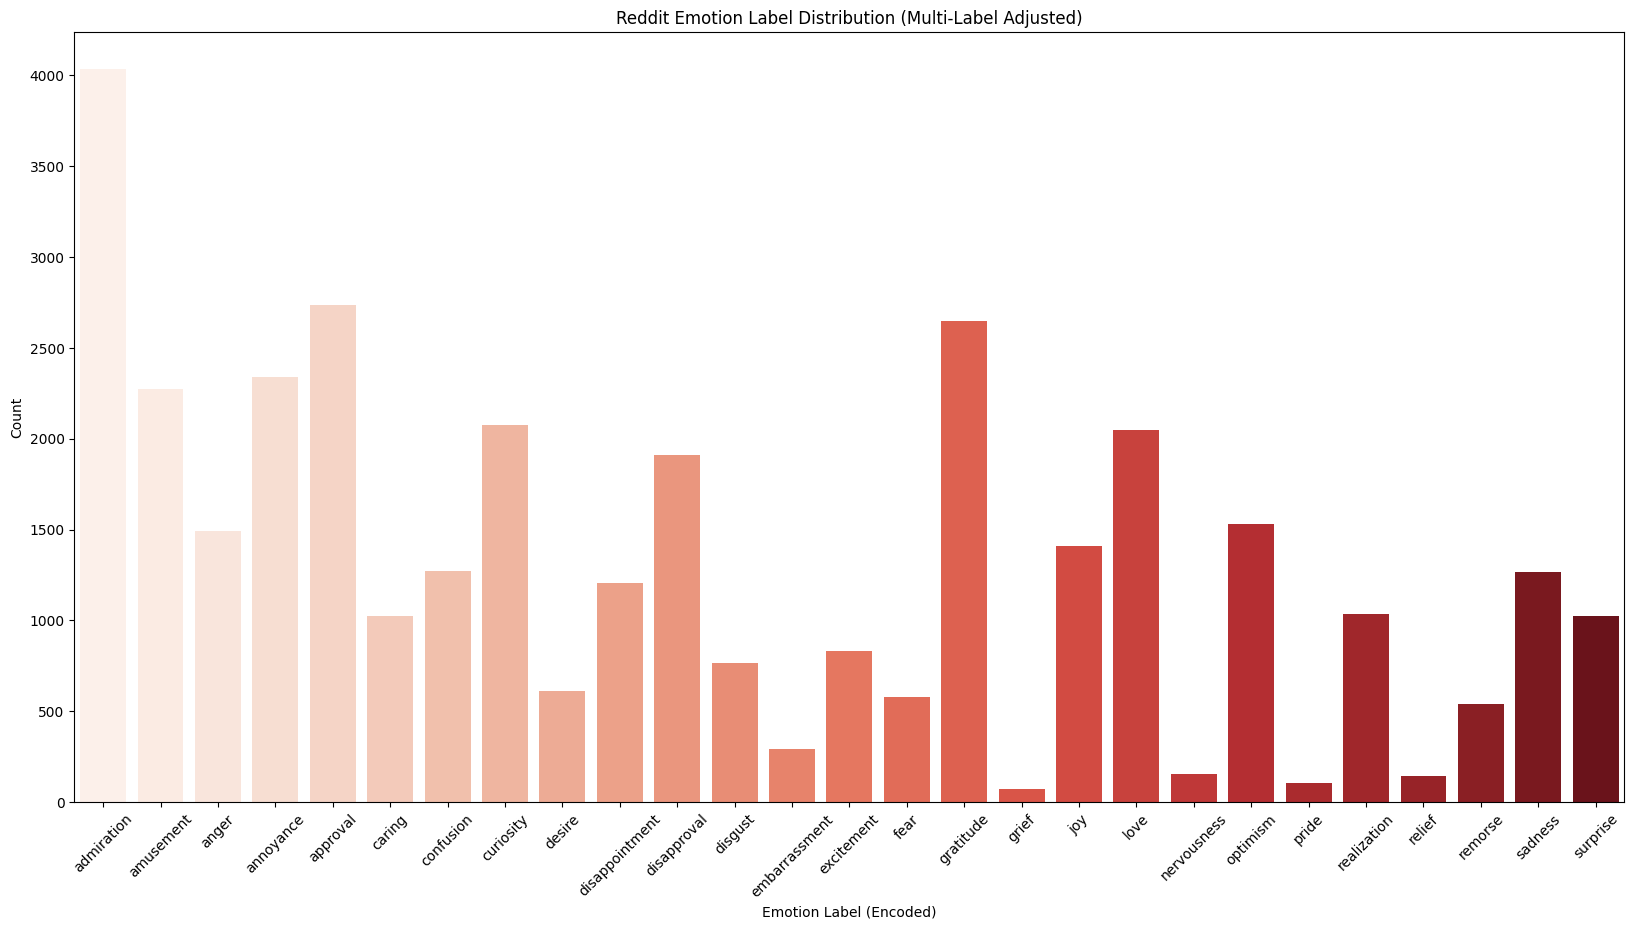

<ipython-input-17-1e2d57fb684e>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=six_list, y=six_label_df["Count"], palette="Reds")


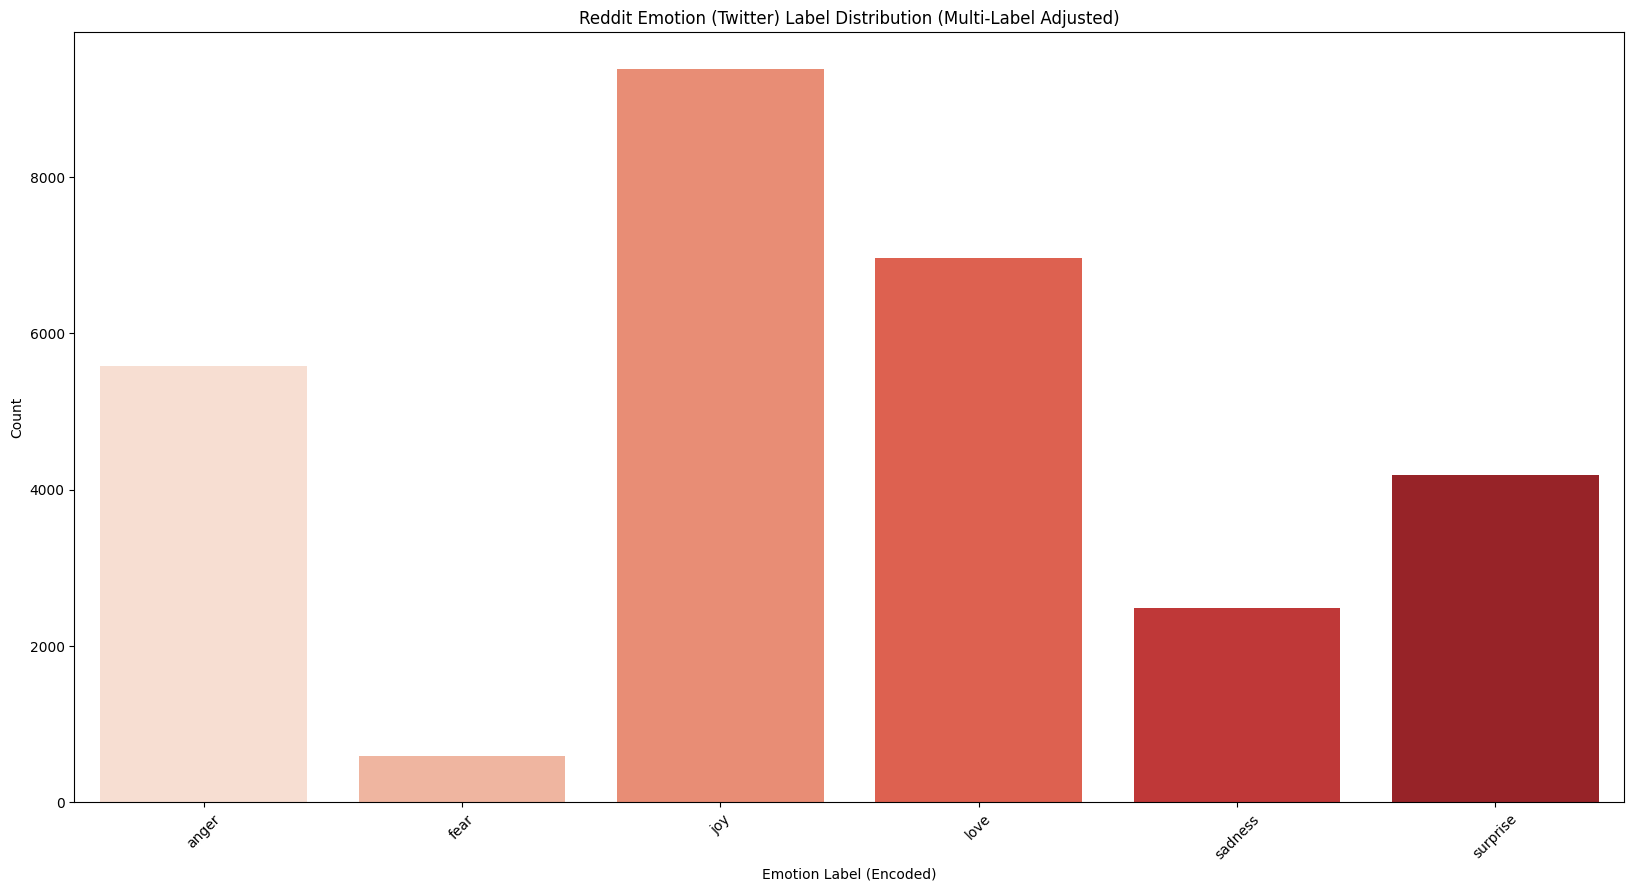

In [17]:
plt.figure(figsize=(20, 10))
sns.barplot(x=emotion_labels, y=label_df["Count"], palette="Reds")
plt.title("Reddit Emotion Label Distribution (Multi-Label Adjusted)")
plt.xlabel("Emotion Label (Encoded)")
plt.ylabel("Count")
#plt.xticks(emotion_labels)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(20, 10))
sns.barplot(x=six_list, y=six_label_df["Count"], palette="Reds")
plt.title("Reddit Emotion (Twitter) Label Distribution (Multi-Label Adjusted)")
plt.xlabel("Emotion Label (Encoded)")
plt.ylabel("Count")
#plt.xticks(emotion_labels)
plt.xticks(rotation=45)
plt.show()

build vocabs

In [18]:
red_train_list = [word for sentence in red_train['text'] for word in preprocess_text(sentence)]
red_train_count = Counter(red_train_list)
red_train_vocab = {word: i + 1 for i, (word, _) in enumerate(red_train_count.most_common())}
red_train_vocab_size = len(red_train_vocab) + 1

red_val_list = [word for sentence in red_val['text'] for word in preprocess_text(sentence)]
red_val_count = Counter(red_val_list)
red_val_vocab = {word: i + 1 for i, (word, _) in enumerate(red_val_count.most_common())}
red_val_vocab_size = len(red_val_vocab) + 1

red_test_list = [word for sentence in red_test['text'] for word in preprocess_text(sentence)]
red_test_count = Counter(red_test_list)
red_test_vocab = {word: i + 1 for i, (word, _) in enumerate(red_test_count.most_common())}
red_test_vocab_size = len(red_test_vocab) + 1

red_train['sequence'] = red_train['text'].apply(text_to_sequence)
red_val['sequence'] = red_val['text'].apply(text_to_sequence)
red_test['sequence'] = red_test['text'].apply(text_to_sequence)

red_max_len = max(
    max(len(seq) for seq in red_train["sequence"]),
    max(len(seq) for seq in red_val["sequence"]),
    max(len(seq) for seq in red_test["sequence"])
)

red_train['padded_sequence'] = red_train['sequence'].apply(lambda seq: seq + [0] * (red_max_len - len(seq)))
num_labels = max(max(l) for l in red_train["label"]) + 1  # Total number of unique labels
red_train['one_hot_label'] = red_train['label'].apply(lambda x: labels_to_one_hot(x, num_labels))
red_X = np.array(red_train['padded_sequence'].tolist())
red_y = np.array(red_train['one_hot_label'].tolist())

red_val['padded_sequence'] = red_val['sequence'].apply(lambda seq: seq + [0] * (red_max_len - len(seq)))
red_val['one_hot_label'] = red_val['label'].apply(lambda x: labels_to_one_hot(x, num_labels))
red_val_X = np.array(red_val['padded_sequence'].tolist())
red_val_y = np.array(red_val['one_hot_label'].tolist())

red_test['padded_sequence'] = red_test['sequence'].apply(lambda seq: seq + [0] * (red_max_len - len(seq)))
red_test['one_hot_label'] = red_test['label'].apply(lambda x: labels_to_one_hot(x, num_labels))
red_test_X = np.array(red_test['padded_sequence'].tolist())
red_test_y = np.array(red_test['one_hot_label'].tolist())

print(f"Training Data Shape: X={red_X.shape}, y={red_y.shape}")
print(f"Validation Data Shape: X={red_val_X.shape}, y={red_val_y.shape}")
print(f"Testing Data Shape: X={red_test_X.shape}, y={red_test_y.shape}")

Training Data Shape: X=(29191, 27), y=(29191, 27)
Validation Data Shape: X=(3660, 27), y=(3660, 27)
Testing Data Shape: X=(3640, 27), y=(3640, 27)


In [19]:
# Save to a JSON file
with open(DATA_DIR + "red_train_vocab.json", "w") as json_file:
    json.dump(red_train_vocab, json_file, indent=4)


In [20]:
# Load tokenizer for bert
bert_tokenizer = BertTokenizer.from_pretrained("bhadresh-savani/bert-base-uncased-emotion")

red_train_bert = red_train.copy()
red_val_bert = red_val.copy()
red_test_bert = red_test.copy()

red_train_bert= bert_tokenizer(
    red_train["text"].tolist(),
    padding="max_length",
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

red_val_bert = bert_tokenizer(
    red_val["text"].tolist(),
    padding="max_length",
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

red_test_bert = bert_tokenizer(
    red_test["text"].tolist(),
    padding="max_length",
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/935 [00:00<?, ?B/s]

In [21]:
# for 28 label emotion classification
class MultiLabelEmotionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(np.vstack(y), dtype=torch.float32)  # Store as float for BCEWithLogitsLoss

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]  # Return one-hot encoded labels

# Create datasets
red_train_dataset = MultiLabelEmotionDataset(red_X, red_y)
red_val_dataset = MultiLabelEmotionDataset(red_val_X, red_val_y)
red_test_dataset = MultiLabelEmotionDataset(red_test_X, red_test_y)

red_train_loader = DataLoader(red_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
red_val_loader = DataLoader(red_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
red_test_loader = DataLoader(red_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [22]:
# for six label emotion classification
class EmotionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
red_six_ED = EmotionDataset(red_X, train_labels)
red_six_loader = DataLoader(red_six_ED, batch_size=BATCH_SIZE, shuffle=True, drop_last = True)

red_six_val = EmotionDataset(red_val_X, val_labels)
red_six_val_loader = DataLoader(red_six_val, batch_size = BATCH_SIZE, shuffle = False, drop_last = True)

red_six_test = EmotionDataset(red_test_X, test_labels)
red_six_test_loader = DataLoader(red_six_test, batch_size = BATCH_SIZE, shuffle = False, drop_last = True)

In [23]:
class BertEmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

# Create datasets
red_bert_train_dataset = BertEmotionDataset(red_train_bert, train_labels)
red_bert_val_dataset = BertEmotionDataset(red_val_bert, val_labels)
red_bert_test_dataset = BertEmotionDataset(red_test_bert, test_labels)

red_bert_train_loader = DataLoader(red_bert_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
red_bert_val_loader = DataLoader(red_bert_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
red_bert_test_loader = DataLoader(red_bert_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model definitions

In [24]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_labels, nlayers, dropout):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, nlayers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_labels)
        self.sigmoid = nn.Sigmoid()
        self.nlayers = nlayers
        self.nhid = hidden_size
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.rnn(embedded, hidden)
        output = self.dropout(output)
        decoded = self.fc(output[:, -1, :])
        return decoded, hidden  # Apply Sigmoid activation

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        return weight.new(self.nlayers, batch_size, self.nhid).zero_()


In [30]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, num_labels, nlayers, dropout=DROPOUT, tie_weights=False):
        super(LSTMModel, self).__init__()
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, nlayers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_labels)
        self.dropout = nn.Dropout(dropout)
        self.nhid = hidden_size
        self.nlayers = nlayers
        self.tie_weights = tie_weights
        self.sigmoid = nn.Sigmoid()  # Multi-label activation

    def init_weights(self):
        initrange = 0.1
        if self.tie_weights:
            assert self.nhid == self.embedding_size, 'incorrect dimensions'
            self.decoder.weight = self.encoder.weight

        self.init_weights()

        # uniform encoding
        self.embedding.weight.data.uniform_(-initrange, initrange)

        # uniform decoding
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()


    def forward(self, input, hidden):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.lstm(embedded, hidden)
        output = self.dropout(output)
        decoded = self.fc(output[:, -1, :])
        #decoded = decoded.view(-1, decoded.size(2))
        return decoded, hidden


    def init_hidden(self, bsz):
        weight = next(self.parameters())
        return (weight.new_zeros(self.nlayers, bsz, self.nhid),
            weight.new_zeros(self.nlayers, bsz, self.nhid))


In [31]:
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, num_labels, nlayers, dropout=DROPOUT, tie_weights=False):
        super(BiLSTMModel, self).__init__()
        self.embedding_size = embedding_size
        self.nhid = hidden_size
        self.dropout = dropout
        self.encoder = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, nlayers, dropout=dropout, batch_first=True, bidirectional=True)
        self.decoder = nn.Linear(hidden_size*2, num_labels)
        self.nlayers = nlayers
        self.tie_weights = tie_weights
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()  # Multi-label activation


    def init_weights(self):
        initrange = 0.1

        if self.tie_weights:
            assert (self.nhid * 2) == self.embedding_size, 'incorrect dimensions'
            self.decoder.weight = self.encoder.weight

        self.init_weights()

        # uniform encoding
        self.encoder.weight.data.uniform_(-initrange, initrange)

        # uniform decoding
        self.decoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()

    def forward(self, input, hidden):
        embedded = self.dropout(self.encoder(input))
        output, hidden = self.lstm(embedded, hidden)
        output = self.dropout(output)
        decoded = self.decoder(output[:, -1, :])
        #decoded = decoded.view(-1, decoded.size(2))
        return decoded, hidden

    def init_hidden(self, batch_size):

        weight = next(self.parameters()).data
        return (weight.new(self.nlayers * 2, batch_size, self.nhid).zero_(),
                weight.new(self.nlayers * 2, batch_size, self.nhid).zero_())

In [32]:
class AttentionRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, num_labels, nlayers, dropout=0.6):
        super(AttentionRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, nlayers, dropout=dropout, batch_first=True, bidirectional=True)
        self.attention = nn.Linear(hidden_size * 2, 1)
        self.fc = nn.Linear(hidden_size * 2, num_labels)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)
        self.nhid = hidden_size
        self.nlayers = nlayers

        nn.init.xavier_uniform_(self.attention.weight)
        nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, input, hidden):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.lstm(embedded, hidden)

        # **Attention mechanism**
        attention_scores = self.attention(output).squeeze(2)
        attention_weights = F.softmax(attention_scores, dim=1)
        context_vector = torch.sum(output * attention_weights.unsqueeze(2), dim=1)

        output = self.dropout(self.fc(context_vector))
        return output, hidden

    def init_hidden(self, batch_size):
        """Initialize hidden state for Attention-RNN"""
        weight = next(self.parameters()).data
        return (weight.new(self.nlayers * 2, batch_size, self.nhid).zero_(),
                weight.new(self.nlayers * 2, batch_size, self.nhid).zero_())


In [33]:
class RNN_Six(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, nlayers, output_size, dropout):
        super(RNN_Six, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.nlayers = nlayers
        self.nhid = hidden_size
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.rnn(embedded, hidden)
        output = self.dropout(output)
        decoded = self.fc(output[:, -1, :])
        #decoded = decoded.view(-1, decoded.size(2))
        return decoded, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        return weight.new(self.nlayers, batch_size, self.nhid).zero_()

In [34]:
class LSTM_Six(nn.Module):
  def __init__(self, vocab_size, embedding_size, hidden_size, nlayers, output_size, dropout=DROPOUT, tie_weights=False):
        super(LSTM_Six, self).__init__()
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, nlayers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
        self.nhid = hidden_size
        self.nlayers = nlayers
        self.tie_weights = tie_weights

  def init_weights(self):
      initrange = 0.1
      if self.tie_weights:
          assert self.nhid == self.embedding_size, 'incorrect dimensions'
          self.decoder.weight = self.encoder.weight

      self.init_weights()

      # uniform encoding
      self.embedding.weight.data.uniform_(-initrange, initrange)

      # uniform decoding
      self.fc.weight.data.uniform_(-initrange, initrange)
      self.fc.bias.data.zero_()

  def forward(self, input, hidden):
      embedded = self.dropout(self.embedding(input))
      output, hidden = self.lstm(embedded, hidden)
      output = self.dropout(output)
      decoded = self.fc(output[:, -1, :])
      #decoded = decoded.view(-1, decoded.size(2))
      return decoded, hidden


  def init_hidden(self, bsz):
      weight = next(self.parameters())
      return (weight.new_zeros(self.nlayers, bsz, self.nhid),
          weight.new_zeros(self.nlayers, bsz, self.nhid))

In [35]:
class BiLSTM_Six(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, nlayers, output_size, dropout=DROPOUT, tie_weights=False):
        super(BiLSTM_Six, self).__init__()
        self.embedding_size = embedding_size
        self.nhid = hidden_size
        self.dropout = dropout
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, nlayers, dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, vocab_size)
        self.nlayers = nlayers
        self.tie_weights = tie_weights
        self.dropout = nn.Dropout(dropout)


    def init_weights(self):
        initrange = 0.1

        if self.tie_weights:
            assert (self.nhid * 2) == self.embedding_size, 'incorrect dimensions'
            self.decoder.weight = self.encoder.weight

        self.init_weights()

        # uniform encoding
        self.embedding.weight.data.uniform_(-initrange, initrange)

        # uniform decoding
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, input, hidden):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.lstm(embedded, hidden)
        output = self.dropout(output)
        decoded = self.fc(output[:, -1, :])
        #decoded = decoded.view(-1, decoded.size(2))
        return decoded, hidden

    def init_hidden(self, batch_size):

        weight = next(self.parameters()).data
        return (weight.new(self.nlayers * 2, batch_size, self.nhid).zero_(),
                weight.new(self.nlayers * 2, batch_size, self.nhid).zero_())

In [36]:
class Attention_Six(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, output_size, nlayers, dropout=0.6):
        super(Attention_Six, self).__init__()
        super(Attention_Six, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, nlayers, dropout=dropout, batch_first=True, bidirectional=True)
        self.attention = nn.Linear(hidden_size * 2, 1)
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.dropout = nn.Dropout(dropout)
        self.nhid = hidden_size
        self.nlayers = nlayers

        nn.init.xavier_uniform_(self.attention.weight)
        nn.init.xavier_uniform_(self.fc.weight)


    def forward(self, input, hidden):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.lstm(embedded, hidden)

        attention_scores = self.attention(output).squeeze(2)
        attention_weights = F.softmax(attention_scores, dim=1)

        context_vector = torch.sum(output * attention_weights.unsqueeze(2), dim=1)
        output = self.fc(context_vector)
        #decoded = decoded.view(-1, decoded.size(2))
        return output, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        return (weight.new(self.nlayers * 2, batch_size, self.nhid).zero_(),
                weight.new(self.nlayers * 2, batch_size, self.nhid).zero_())

In [37]:
# Define how we compute F1-score and Accuracy
def compute_metrics(pred):
    logits, labels = pred
    predictions = logits.argmax(axis=-1)  # Get predicted class

    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")  # Weighted F1-score

    return {
        "accuracy": accuracy,
        "f1": f1
    }

In [ ]:
#bert model
from transformers import Trainer, TrainingArguments, BertForSequenceClassification

# Load BERT model
bert_model = BertForSequenceClassification.from_pretrained("bhadresh-savani/bert-base-uncased-emotion")

# Define Training Arguments
training_args = TrainingArguments(
    output_dir="results_reddit_6",
    num_train_epochs=3,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_steps=500,
    report_to="none",
    fp16=True
)

# Define Trainer
red_bert_trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=red_bert_train_dataset,
    eval_dataset=red_bert_val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
red_bert_trainer.train()

torch.save(red_bert_trainer, RESULTS_DIR + "red_bert.pth")

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.829700,0.725255,0.743716,0.743553
2,0.581800,0.711382,0.760383,0.759645
3,0.413700,0.818191,0.755738,0.755454


In [ ]:
red_bert_trainer.save_model(RESULTS_DIR + "red_bert_model")

In [ ]:
bert_model = BertForSequenceClassification.from_pretrained(RESULTS_DIR + "red_bert_model")
bert_model.to(device)
bert_model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [41]:
# --- Training function 28 label ---

def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=5, bptt=50):
    model.to(device)
    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        total_loss, total_correct, total_samples = 0, 0, 0

        for batch in train_loader:
            inputs, labels = batch[0].to(device), batch[1].to(device)
            optimizer.zero_grad()
            hidden = model.init_hidden(inputs.size(0))
            loss = 0

            # implement bptt
            for t in range(0, inputs.size(1), bptt):
                chunk = inputs[:, t:t + bptt]
                if isinstance(hidden, tuple):  # LSTM case
                    hidden = (hidden[0].detach(), hidden[1].detach())
                else:  # RNN case
                    hidden = hidden.detach()
                outputs, hidden = model(chunk, hidden)
                loss += criterion(outputs, labels)

            loss.backward()  # backpropagation
            optimizer.step()

            total_loss += loss.item()
            predictions = (outputs > 0.5).float()
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.numel()

        avg_loss = total_loss / len(train_loader)
        avg_accuracy = total_correct / total_samples
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Train Acc: {avg_accuracy:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    return model

In [42]:
# --- Evaluation function 28 label ---

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss, total_correct, total_samples = 0, 0, 0

    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch[0].to(device), batch[1].to(device)

            # handle models with hidden states (RNNs, LSTMs)
            if hasattr(model, "init_hidden"):
                hidden = model.init_hidden(inputs.size(0))
                if isinstance(hidden, tuple):
                    hidden = (hidden[0].detach(), hidden[1].detach())
                else:
                    hidden = hidden.detach()
                outputs, _ = model(inputs, hidden)
            else:
                outputs = model(inputs)  # attention rnn

            loss = criterion(outputs, labels)
            total_loss += loss.item()
            predictions = (outputs > 0.5).float()
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.numel()

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_correct / total_samples  # Compute accuracy

    return avg_loss, avg_accuracy


In [43]:
# --- Training function 6 label ---

def train_six(model, train_loader, val_loader, optimizer, criterion, device, epochs=5, bptt=50):
    model.to(device)
    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        total_loss, total_correct = 0, 0

        for batch in train_loader:
            inputs, labels = batch[0].to(device), batch[1].to(device)
            optimizer.zero_grad()
            hidden = model.init_hidden(inputs.size(0))
            loss = 0

            # implement bptt
            for t in range(0, inputs.size(1), bptt):
                chunk = inputs[:, t:t + bptt]
                outputs, hidden = model(chunk, hidden)
                loss += criterion(outputs, labels)

            loss.backward()  # backpropagation
            optimizer.step()

            total_loss += loss.item()
            total_correct += (outputs.argmax(1) == labels).sum().item()

        avg_loss = total_loss / len(train_loader)
        accuracy = total_correct / len(train_loader.dataset)
        val_loss, val_acc = eval_six(model, val_loader, criterion, device)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Train Acc: {accuracy:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    return model

In [44]:
# --- Evaluation function 6 label ---
def eval_six(model, dataloader, criterion, device):
    model.eval()
    total_loss, total_correct = 0, 0

    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch[0].to(device), batch[1].to(device)
            abels = labels.long()

            # handle models with hidden states (RNNs, LSTMs)
            if hasattr(model, "init_hidden"):
                hidden = model.init_hidden(inputs.size(0))
                if isinstance(hidden, tuple):
                    hidden = (hidden[0].detach(), hidden[1].detach())
                else:
                    hidden = hidden.detach()
                outputs, _ = model(inputs, hidden)
            else:
                outputs = model(inputs)  # attention rnn

            loss = criterion(outputs, labels)
            total_loss += loss.item()
            total_correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / len(dataloader.dataset)

    return avg_loss, accuracy

In [48]:
six_criterion = torch.nn.CrossEntropyLoss()
num_labels = 6

In [ ]:
# Train six-label vanilla RNN
red_six_vanilla = RNN_Six(red_train_vocab_size, WORD_EMBED_DIM, HID_EMBED_DIM, 1, 6, DROPOUT)
red_six_vanilla = train_six(red_six_vanilla, red_six_loader, red_six_val_loader,torch.optim.Adam(red_six_vanilla.parameters()), six_criterion, device, epochs=EPOCHS, bptt=BPTT )

torch.save(red_six_vanilla.state_dict(), RESULTS_DIR + "red_six_vanilla.pth")

Epoch 1/30 | Train Loss: 1.6462 | Train Acc: 0.2902 | Val Loss: 1.5891 | Val Acc: 0.3388
Epoch 2/30 | Train Loss: 1.6210 | Train Acc: 0.3027 | Val Loss: 1.5797 | Val Acc: 0.3388
Epoch 3/30 | Train Loss: 1.6153 | Train Acc: 0.3046 | Val Loss: 1.5916 | Val Acc: 0.3388
Epoch 4/30 | Train Loss: 1.6161 | Train Acc: 0.2995 | Val Loss: 1.5768 | Val Acc: 0.3388
Epoch 5/30 | Train Loss: 1.6166 | Train Acc: 0.3003 | Val Loss: 1.5830 | Val Acc: 0.3388
Epoch 6/30 | Train Loss: 1.6148 | Train Acc: 0.3001 | Val Loss: 1.5846 | Val Acc: 0.3388
Epoch 7/30 | Train Loss: 1.6158 | Train Acc: 0.3024 | Val Loss: 1.5803 | Val Acc: 0.3388
Epoch 8/30 | Train Loss: 1.6145 | Train Acc: 0.3048 | Val Loss: 1.5835 | Val Acc: 0.3388
Epoch 9/30 | Train Loss: 1.6135 | Train Acc: 0.3039 | Val Loss: 1.5894 | Val Acc: 0.3388
Epoch 10/30 | Train Loss: 1.6153 | Train Acc: 0.3009 | Val Loss: 1.5812 | Val Acc: 0.3388
Epoch 11/30 | Train Loss: 1.6175 | Train Acc: 0.3017 | Val Loss: 1.5805 | Val Acc: 0.3388
Epoch 12/30 | Train

In [ ]:
# Train unidirectional six-label LSTM
red_six_lstm = LSTM_Six(red_train_vocab_size, WORD_EMBED_DIM, HID_EMBED_DIM, 2, 6, dropout=DROPOUT)
red_six_lstm = train_six(red_six_lstm, red_six_loader, red_six_val_loader, torch.optim.Adam(red_six_lstm.parameters()), six_criterion, device, epochs=EPOCHS, bptt=BPTT)

torch.save(red_six_lstm.state_dict(), RESULTS + "red_six_lstm.pth")

Epoch 1/30 | Train Loss: 1.6013 | Train Acc: 0.3159 | Val Loss: 1.5803 | Val Acc: 0.3388
Epoch 2/30 | Train Loss: 1.5416 | Train Acc: 0.3362 | Val Loss: 1.4156 | Val Acc: 0.3932
Epoch 3/30 | Train Loss: 1.4098 | Train Acc: 0.3907 | Val Loss: 1.3061 | Val Acc: 0.4284
Epoch 4/30 | Train Loss: 1.2800 | Train Acc: 0.4836 | Val Loss: 1.1658 | Val Acc: 0.5495
Epoch 5/30 | Train Loss: 1.1774 | Train Acc: 0.5470 | Val Loss: 1.1243 | Val Acc: 0.5839
Epoch 6/30 | Train Loss: 1.1060 | Train Acc: 0.5930 | Val Loss: 1.0491 | Val Acc: 0.6172
Epoch 7/30 | Train Loss: 1.0429 | Train Acc: 0.6214 | Val Loss: 1.0390 | Val Acc: 0.6216
Epoch 8/30 | Train Loss: 0.9914 | Train Acc: 0.6439 | Val Loss: 1.0109 | Val Acc: 0.6361
Epoch 9/30 | Train Loss: 0.9505 | Train Acc: 0.6608 | Val Loss: 1.0096 | Val Acc: 0.6402
Epoch 10/30 | Train Loss: 0.9170 | Train Acc: 0.6754 | Val Loss: 1.0227 | Val Acc: 0.6410
Epoch 11/30 | Train Loss: 0.8860 | Train Acc: 0.6856 | Val Loss: 1.0147 | Val Acc: 0.6448
Epoch 12/30 | Train

In [ ]:
# Train bidirectional six-label LSTM
red_six_bilstm = BiLSTM_Six(red_train_vocab_size, WORD_EMBED_DIM, HID_EMBED_DIM, 2, 6, dropout=DROPOUT)
red_six_bilstm = train_six(red_six_bilstm, red_six_loader, red_six_val_loader, torch.optim.Adam(red_six_bilstm.parameters()), six_criterion, device, epochs=EPOCHS, bptt=BPTT)

torch.save(red_six_bilstm.state_dict(), RESULTS_DIR + "red_six_bilstm.pth")

Epoch 1/30 | Train Loss: 1.7529 | Train Acc: 0.2777 | Val Loss: 1.5931 | Val Acc: 0.3388
Epoch 2/30 | Train Loss: 1.6221 | Train Acc: 0.3008 | Val Loss: 1.5823 | Val Acc: 0.3388
Epoch 3/30 | Train Loss: 1.6178 | Train Acc: 0.3007 | Val Loss: 1.5847 | Val Acc: 0.3388
Epoch 4/30 | Train Loss: 1.6135 | Train Acc: 0.3058 | Val Loss: 1.5766 | Val Acc: 0.3388
Epoch 5/30 | Train Loss: 1.6081 | Train Acc: 0.3073 | Val Loss: 1.5841 | Val Acc: 0.3388
Epoch 6/30 | Train Loss: 1.6061 | Train Acc: 0.3094 | Val Loss: 1.5888 | Val Acc: 0.3388
Epoch 7/30 | Train Loss: 1.6062 | Train Acc: 0.3111 | Val Loss: 1.5845 | Val Acc: 0.3388
Epoch 8/30 | Train Loss: 1.6043 | Train Acc: 0.3117 | Val Loss: 1.5854 | Val Acc: 0.3388
Epoch 9/30 | Train Loss: 1.6011 | Train Acc: 0.3155 | Val Loss: 1.5823 | Val Acc: 0.3388
Epoch 10/30 | Train Loss: 1.4854 | Train Acc: 0.3518 | Val Loss: 1.3864 | Val Acc: 0.4249
Epoch 11/30 | Train Loss: 1.3262 | Train Acc: 0.4504 | Val Loss: 1.2035 | Val Acc: 0.5369
Epoch 12/30 | Train

In [ ]:
# Train six-label attention-based RNN
red_six_attention = Attention_Six(red_train_vocab_size, WORD_EMBED_DIM, HID_EMBED_DIM, 6, 1)
red_six_attention = train_six(red_six_attention, red_six_loader, red_six_val_loader, torch.optim.Adam(red_six_attention.parameters()), six_criterion, device, epochs=EPOCHS, bptt=BPTT)

torch.save(red_six_attention.state_dict(), RESULTS_DIR + "red_six_attention.pth")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn(


Epoch 1/30 | Train Loss: 1.3035 | Train Acc: 0.4901 | Val Loss: 1.0969 | Val Acc: 0.5989
Epoch 2/30 | Train Loss: 1.1220 | Train Acc: 0.5801 | Val Loss: 1.0208 | Val Acc: 0.6339
Epoch 3/30 | Train Loss: 1.0324 | Train Acc: 0.6193 | Val Loss: 0.9891 | Val Acc: 0.6486
Epoch 4/30 | Train Loss: 0.9686 | Train Acc: 0.6490 | Val Loss: 0.9749 | Val Acc: 0.6631
Epoch 5/30 | Train Loss: 0.9261 | Train Acc: 0.6627 | Val Loss: 0.9906 | Val Acc: 0.6563
Epoch 6/30 | Train Loss: 0.8835 | Train Acc: 0.6747 | Val Loss: 0.9820 | Val Acc: 0.6672
Epoch 7/30 | Train Loss: 0.8534 | Train Acc: 0.6895 | Val Loss: 1.0114 | Val Acc: 0.6664
Epoch 8/30 | Train Loss: 0.8229 | Train Acc: 0.7019 | Val Loss: 1.0261 | Val Acc: 0.6708
Epoch 9/30 | Train Loss: 0.7928 | Train Acc: 0.7124 | Val Loss: 1.0471 | Val Acc: 0.6675
Epoch 10/30 | Train Loss: 0.7672 | Train Acc: 0.7214 | Val Loss: 1.0688 | Val Acc: 0.6705
Epoch 11/30 | Train Loss: 0.7409 | Train Acc: 0.7317 | Val Loss: 1.0790 | Val Acc: 0.6691
Epoch 12/30 | Train

In [55]:
criterion = torch.nn.BCEWithLogitsLoss()
num_labels = 27

In [ ]:
# Train 28-label Vanilla RNN
red_vanilla_model = RNNModel(red_train_vocab_size, WORD_EMBED_DIM, HID_EMBED_DIM, num_labels, 1, DROPOUT)
red_vanilla_model = train_model(red_vanilla_model, red_train_loader, red_val_loader,torch.optim.Adam(red_vanilla_model.parameters(), lr=0.0005), criterion, device, epochs=EPOCHS, bptt=BPTT )

torch.save(red_vanilla_model.state_dict(), RESULTS_DIR + "red_vanilla_model.pth")

Epoch 1/30 | Train Loss: 0.1832 | Train Acc: 0.9546 | Val Loss: 0.1721 | Val Acc: 0.9552
Epoch 2/30 | Train Loss: 0.1754 | Train Acc: 0.9551 | Val Loss: 0.1712 | Val Acc: 0.9552
Epoch 3/30 | Train Loss: 0.1742 | Train Acc: 0.9551 | Val Loss: 0.1717 | Val Acc: 0.9552
Epoch 4/30 | Train Loss: 0.1737 | Train Acc: 0.9551 | Val Loss: 0.1717 | Val Acc: 0.9552
Epoch 5/30 | Train Loss: 0.1734 | Train Acc: 0.9551 | Val Loss: 0.1712 | Val Acc: 0.9552
Epoch 6/30 | Train Loss: 0.1731 | Train Acc: 0.9551 | Val Loss: 0.1709 | Val Acc: 0.9552
Epoch 7/30 | Train Loss: 0.1730 | Train Acc: 0.9551 | Val Loss: 0.1711 | Val Acc: 0.9552
Epoch 8/30 | Train Loss: 0.1730 | Train Acc: 0.9551 | Val Loss: 0.1715 | Val Acc: 0.9552
Epoch 9/30 | Train Loss: 0.1730 | Train Acc: 0.9551 | Val Loss: 0.1715 | Val Acc: 0.9552
Epoch 10/30 | Train Loss: 0.1730 | Train Acc: 0.9551 | Val Loss: 0.1712 | Val Acc: 0.9552
Epoch 11/30 | Train Loss: 0.1729 | Train Acc: 0.9551 | Val Loss: 0.1711 | Val Acc: 0.9552
Epoch 12/30 | Train

In [ ]:
# Train 28-label unidirectional LSTM
red_lstm_model = LSTMModel(red_train_vocab_size, WORD_EMBED_DIM, HID_EMBED_DIM, num_labels, 2, dropout=DROPOUT)
red_lstm_model = train_model(red_lstm_model, red_train_loader, red_val_loader, torch.optim.Adam(red_lstm_model.parameters(), lr=0.0005), criterion, device, epochs=EPOCHS, bptt=BPTT)

torch.save(red_lstm_model.state_dict(), RESULTS_DIR + "red_lstm_model.pth")

Epoch 1/30 | Train Loss: 0.1828 | Train Acc: 0.9551 | Val Loss: 0.1712 | Val Acc: 0.9552
Epoch 2/30 | Train Loss: 0.1739 | Train Acc: 0.9551 | Val Loss: 0.1710 | Val Acc: 0.9552
Epoch 3/30 | Train Loss: 0.1730 | Train Acc: 0.9551 | Val Loss: 0.1709 | Val Acc: 0.9552
Epoch 4/30 | Train Loss: 0.1725 | Train Acc: 0.9551 | Val Loss: 0.1709 | Val Acc: 0.9552
Epoch 5/30 | Train Loss: 0.1723 | Train Acc: 0.9551 | Val Loss: 0.1709 | Val Acc: 0.9552
Epoch 6/30 | Train Loss: 0.1722 | Train Acc: 0.9551 | Val Loss: 0.1707 | Val Acc: 0.9552
Epoch 7/30 | Train Loss: 0.1715 | Train Acc: 0.9551 | Val Loss: 0.1636 | Val Acc: 0.9552
Epoch 8/30 | Train Loss: 0.1612 | Train Acc: 0.9572 | Val Loss: 0.1523 | Val Acc: 0.9582
Epoch 9/30 | Train Loss: 0.1519 | Train Acc: 0.9585 | Val Loss: 0.1414 | Val Acc: 0.9595
Epoch 10/30 | Train Loss: 0.1426 | Train Acc: 0.9593 | Val Loss: 0.1315 | Val Acc: 0.9622
Epoch 11/30 | Train Loss: 0.1348 | Train Acc: 0.9617 | Val Loss: 0.1267 | Val Acc: 0.9637
Epoch 12/30 | Train

In [ ]:
# Train 28-label biidirectional LSTM
red_bilstm_model = BiLSTMModel(red_train_vocab_size, WORD_EMBED_DIM, HID_EMBED_DIM, num_labels, 2, dropout=DROPOUT)
red_bilstm_model = train_model(red_bilstm_model, red_train_loader, red_val_loader, torch.optim.Adam(red_bilstm_model.parameters(), lr=0.0005), criterion, device, epochs=EPOCHS, bptt=BPTT)

torch.save(red_bilstm_model.state_dict(), RESULTS_DIR + "red_bilstm_model.pth")

Epoch 1/30 | Train Loss: 0.1803 | Train Acc: 0.9551 | Val Loss: 0.1710 | Val Acc: 0.9552
Epoch 2/30 | Train Loss: 0.1730 | Train Acc: 0.9551 | Val Loss: 0.1710 | Val Acc: 0.9552
Epoch 3/30 | Train Loss: 0.1724 | Train Acc: 0.9551 | Val Loss: 0.1709 | Val Acc: 0.9552
Epoch 4/30 | Train Loss: 0.1722 | Train Acc: 0.9551 | Val Loss: 0.1710 | Val Acc: 0.9552
Epoch 5/30 | Train Loss: 0.1720 | Train Acc: 0.9551 | Val Loss: 0.1710 | Val Acc: 0.9552
Epoch 6/30 | Train Loss: 0.1719 | Train Acc: 0.9551 | Val Loss: 0.1709 | Val Acc: 0.9552
Epoch 7/30 | Train Loss: 0.1699 | Train Acc: 0.9551 | Val Loss: 0.1596 | Val Acc: 0.9552
Epoch 8/30 | Train Loss: 0.1551 | Train Acc: 0.9578 | Val Loss: 0.1462 | Val Acc: 0.9596
Epoch 9/30 | Train Loss: 0.1463 | Train Acc: 0.9600 | Val Loss: 0.1388 | Val Acc: 0.9612
Epoch 10/30 | Train Loss: 0.1409 | Train Acc: 0.9615 | Val Loss: 0.1350 | Val Acc: 0.9630
Epoch 11/30 | Train Loss: 0.1362 | Train Acc: 0.9623 | Val Loss: 0.1312 | Val Acc: 0.9631
Epoch 12/30 | Train

In [ ]:
# Train 28-label attentional RNN
red_attention_model = AttentionRNN(red_train_vocab_size, WORD_EMBED_DIM, HID_EMBED_DIM, num_labels, 1, 0.6)
red_attention_model = train_model(red_attention_model, red_train_loader, red_val_loader, torch.optim.Adam(red_attention_model.parameters(), lr=0.0003), criterion, device, epochs=EPOCHS, bptt=BPTT)

torch.save(red_attention_model.state_dict(), RESULTS_DIR + "red_attention_model.pth")

Epoch 1/30 | Train Loss: 0.4873 | Train Acc: 0.9550 | Val Loss: 0.2827 | Val Acc: 0.9552
Epoch 2/30 | Train Loss: 0.4841 | Train Acc: 0.9552 | Val Loss: 0.2679 | Val Acc: 0.9577
Epoch 3/30 | Train Loss: 0.4759 | Train Acc: 0.9568 | Val Loss: 0.2431 | Val Acc: 0.9619
Epoch 4/30 | Train Loss: 0.4706 | Train Acc: 0.9574 | Val Loss: 0.2233 | Val Acc: 0.9638
Epoch 5/30 | Train Loss: 0.4682 | Train Acc: 0.9578 | Val Loss: 0.2285 | Val Acc: 0.9648
Epoch 6/30 | Train Loss: 0.4657 | Train Acc: 0.9581 | Val Loss: 0.2117 | Val Acc: 0.9652
Epoch 7/30 | Train Loss: 0.4658 | Train Acc: 0.9583 | Val Loss: 0.2127 | Val Acc: 0.9656
Epoch 8/30 | Train Loss: 0.4634 | Train Acc: 0.9583 | Val Loss: 0.2048 | Val Acc: 0.9659
Epoch 9/30 | Train Loss: 0.4626 | Train Acc: 0.9585 | Val Loss: 0.2000 | Val Acc: 0.9664
Epoch 10/30 | Train Loss: 0.4625 | Train Acc: 0.9587 | Val Loss: 0.1955 | Val Acc: 0.9669
Epoch 11/30 | Train Loss: 0.4610 | Train Acc: 0.9590 | Val Loss: 0.1911 | Val Acc: 0.9671
Epoch 12/30 | Train

In [60]:
def visualize_attention(model, sample_text, vocab):
    model.eval()
    tokens = [word for word in sample_text.split() if word in vocab]  # Keep only known words
    token_ids = [vocab[word] for word in tokens]  # Convert to IDs

    if not token_ids:
        print("Error: No words from sample_text found in vocab!")
        return

    token_ids = torch.tensor(token_ids).unsqueeze(0).to(device)

    with torch.no_grad():
        embedded = model.embedding(token_ids)
        output, _ = model.lstm(embedded)
        attention_scores = model.attention(output).squeeze(2)
        attention_weights = torch.softmax(attention_scores, dim=1).cpu().numpy().flatten()

    #ensure the correct number of labels matches the attention weights
    if len(tokens) != len(attention_weights):
        tokens = tokens[:len(attention_weights)]  # Trim words to match attention length

    plt.figure(figsize=(10, 3))
    plt.bar(tokens, attention_weights)
    plt.title("Attention Weights per Word")
    plt.xlabel("Words in Text")
    plt.ylabel("Attention Weight")
    plt.show()


In [ ]:
#LOAD IN MODELS
#ONLY RUN IF NOT ALREADY LOADED IN

MODEL_PATHS = {
    "Vanilla RNN": RESULTS_DIR + "red_vanilla_model.pth",
    "LSTM": RESULTS_DIR + "red_lstm_model.pth",
    "BiLSTM": RESULTS_DIR + "red_bilstm_model.pth",
    "Attention RNN": RESULTS_DIR + "red_attention_model.pth",

}
# Load models for 28 labels

trained_models = {}
red_vanilla_model = RNNModel(red_train_vocab_size, WORD_EMBED_DIM, HID_EMBED_DIM, num_labels, 1, DROPOUT)
if ~torch.cuda.is_available():
  red_vanilla_model.load_state_dict(torch.load(MODEL_PATHS["Vanilla RNN"], map_location=torch.device('cpu')))
else:
  red_vanilla_model.load_state_dict(torch.load(MODEL_PATHS["Vanilla RNN"]), strict=False)
red_vanilla_model.to(device)
trained_models["vanilla rnn"] = red_vanilla_model.eval()

red_lstm_model = LSTMModel(red_train_vocab_size, WORD_EMBED_DIM, HID_EMBED_DIM, num_labels, 2, dropout=DROPOUT)
if ~torch.cuda.is_available():
  red_lstm_model.load_state_dict(torch.load(MODEL_PATHS["LSTM"], map_location=torch.device('cpu')), strict=False)
else:
  red_lstm_model.load_state_dict(torch.load(MODEL_PATHS["LSTM"]))
red_lstm_model.to(device)
trained_models["lstm"] = red_lstm_model.eval()

red_bilstm_model = BiLSTMModel(red_train_vocab_size, WORD_EMBED_DIM, HID_EMBED_DIM, num_labels, 2, dropout=DROPOUT)
if ~torch.cuda.is_available():
  red_bilstm_model.load_state_dict(torch.load(MODEL_PATHS["BiLSTM"], map_location=torch.device('cpu')))
else:
  red_bilstm_model.load_state_dict(torch.load(MODEL_PATHS["BiLSTM"]))
red_bilstm_model.to(device)
trained_models["bilstm"] = red_bilstm_model.eval()

red_attention_model = AttentionRNN(red_train_vocab_size, WORD_EMBED_DIM, HID_EMBED_DIM, num_labels, 1, 0.6)
if ~torch.cuda.is_available():
  red_attention_model.load_state_dict(torch.load(MODEL_PATHS["Attention RNN"], map_location=torch.device('cpu')))
else:
  red_attention_model.load_state_dict(torch.load(MODEL_PATHS["Attention RNN"]))
red_attention_model.to(device)
trained_models["attention"] = red_attention_model.eval()


<ipython-input-48-fae39ea76d75>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  red_vanilla_model.load_state_dict(torch.load(MODEL_PATHS["Vanilla RNN"], map_location=torch

In [ ]:
#LOAD IN MODELS
#ONLY RUN IF NOT ALREADY LOADED IN

MODEL_PATHS_SIX = {
    "Vanilla RNN": RESULTS_DIR + "red_six_vanilla.pth",
    "LSTM": RESULTS_DIR + "red_six_lstm.pth",
    "BiLSTM": RESULTS_DIR + "red_six_bilstm.pth",
    "Attention RNN": RESULTS_DIR + "red_six_attention.pth",

}
# Load models for 6 labels
num_labels = 6

trained_models = {}
red_vanilla_model = RNNModel(red_train_vocab_size, WORD_EMBED_DIM, HID_EMBED_DIM, num_labels, 1, DROPOUT)
if ~torch.cuda.is_available():
  red_vanilla_model.load_state_dict(torch.load(MODEL_PATHS_SIX["Vanilla RNN"], map_location=torch.device('cpu')))
else:
  red_vanilla_model.load_state_dict(torch.load(MODEL_PATHS_SIX["Vanilla RNN"]), strict=False)
red_vanilla_model.to(device)
trained_models["vanilla rnn"] = red_vanilla_model.eval()

red_lstm_model = LSTMModel(red_train_vocab_size, WORD_EMBED_DIM, HID_EMBED_DIM, num_labels, 2, dropout=DROPOUT)
if ~torch.cuda.is_available():
  red_lstm_model.load_state_dict(torch.load(MODEL_PATHS_SIX["LSTM"], map_location=torch.device('cpu')), strict=False)
else:
  red_lstm_model.load_state_dict(torch.load(MODEL_PATHS_SIX["LSTM"]))
red_lstm_model.to(device)
trained_models["lstm"] = red_lstm_model.eval()

red_bilstm_model = BiLSTMModel(red_train_vocab_size, WORD_EMBED_DIM, HID_EMBED_DIM, num_labels, 2, dropout=DROPOUT)
if ~torch.cuda.is_available():
  red_bilstm_model.load_state_dict(torch.load(MODEL_PATHS_SIX["BiLSTM"], map_location=torch.device('cpu')))
else:
  red_bilstm_model.load_state_dict(torch.load(MODEL_PATHS_SIX["BiLSTM"]))
red_bilstm_model.to(device)
trained_models["bilstm"] = red_bilstm_model.eval()

red_attention_model = AttentionRNN(red_train_vocab_size, WORD_EMBED_DIM, HID_EMBED_DIM, num_labels, 1, 0.6)
if ~torch.cuda.is_available():
  red_attention_model.load_state_dict(torch.load(MODEL_PATHS_SIX["Attention RNN"], map_location=torch.device('cpu')))
else:
  red_attention_model.load_state_dict(torch.load(MODEL_PATHS_SIX["Attention RNN"]))
red_attention_model.to(device)
trained_models["attention"] = red_attention_model.eval()


In [77]:
#IF MODELS ARE ALREADY LOADED IN


test_results = {}

trained_models = {
    "Vanilla RNN": red_vanilla_model,
    "LSTM": red_lstm_model,
    "BiLSTM": red_bilstm_model,
    "Attention RNN": red_attention_model
}

trained_models_six = {
    "Vanilla RNN": red_six_vanilla,
    "LSTM": red_six_lstm,
    "BiLSTM": red_six_bilstm,
    "Attention RNN": red_six_attention,
 }

In [78]:
def detach_hidden(hidden):
      if isinstance(hidden, tuple):  # LSTM case
          return (hidden[0].detach(), hidden[1].detach())
      return hidden.detach()

In [94]:
# Store test results for each model separately
# 28 labels
model_predictions = {}
model_labels = {}

test_results = {}

for model_name, model in trained_models.items():
    all_preds, all_labels = [], []
    total_loss = 0
    num_batches = 0

    model.eval()
    with torch.no_grad():
        for batch in red_test_loader:
            inputs, labels = batch[0].to(device), batch[1].to(device)

            batch_size = inputs.size(0)
            hidden = model.init_hidden(batch_size)
            hidden = detach_hidden(hidden)
            outputs, hidden = model(inputs, hidden)

            loss = criterion(outputs, labels)
            total_loss += loss.item()
            num_batches += 1

            preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
            labels = labels.cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    model_predictions[model_name] = np.array(all_preds)
    model_labels[model_name] = np.array(all_labels)

    accuracy = accuracy_score(all_labels.flatten(), all_preds.flatten()) * 100  # Percentage
    f1 = f1_score(all_labels.flatten(), all_preds.flatten(), average="weighted")  # Multi-label F1-score
    avg_loss = total_loss / num_batches  # Compute average loss

    test_results[model_name] = {
        "Accuracy (%)": accuracy,
        "F1-Score": f1,
        "Cross-Entropy Loss": avg_loss
    }
    print(f"{model_name}: Accuracy = {accuracy:.2f}%, F1-Score = {f1:.4f}, Loss = {avg_loss:.4f}")

df_test_results = pd.DataFrame(test_results).T

Vanilla RNN: Accuracy = 95.57%, F1-Score = 0.9341, Loss = 3.6437
LSTM: Accuracy = 96.69%, F1-Score = 0.9631, Loss = 2.5859
BiLSTM: Accuracy = 96.71%, F1-Score = 0.9630, Loss = 2.5394
Attention RNN: Accuracy = 96.54%, F1-Score = 0.9631, Loss = 2.2636


In [95]:
# 6 labels
model_predictions_six = {}
model_labels_six = {}

test_results_six = {}

for name, model in trained_models_six.items():
      all_preds, all_labels = [], []

      total_loss = 0
      num_batches = 0

      model.eval()
      with torch.no_grad():
          for batch in red_six_test_loader:
              inputs, labels = batch[0].to(device), batch[1].to(device)

              batch_size = inputs.size(0)
              hidden = model.init_hidden(batch_size)

              hidden = detach_hidden(hidden)

              outputs, hidden = model(inputs, hidden)

              loss = F.cross_entropy(outputs, labels)
              total_loss += loss.item()
              num_batches += 1

              preds = torch.argmax(outputs, dim=1).cpu().numpy()
              labels = labels.cpu().numpy()

              all_preds.extend(preds)
              all_labels.extend(labels)

      all_preds = np.array(all_preds)
      all_labels = np.array(all_labels)

      model_predictions_six[model_name] = np.array(all_preds)
      model_labels_six[model_name] = np.array(all_labels)

      # evaluation metrics
      accuracy = accuracy_score(all_labels, all_preds) * 100
      f1 = f1_score(all_labels, all_preds, average="weighted")
      conf_matrix = confusion_matrix(all_labels, all_preds)
      avg_loss = total_loss / num_batches

      test_results_six[name] = {"Accuracy (%)": accuracy, "F1-Score": f1, "Cross-Entropy Loss": avg_loss}
      print(f"{name}: Accuracy = {accuracy:.2f}%, F1-Score = {f1:.4f}")

df_test_results_six = pd.DataFrame(test_results_six).T

Vanilla RNN: Accuracy = 31.39%, F1-Score = 0.1500
LSTM: Accuracy = 65.81%, F1-Score = 0.6570
BiLSTM: Accuracy = 65.11%, F1-Score = 0.6487
Attention RNN: Accuracy = 65.50%, F1-Score = 0.6535


In [96]:
#bert results

b_all_labels = []
b_all_preds = []
b_total_loss = 0

import os

bert_model.to(device)
bert_model.eval()

with torch.no_grad():
  for batch in red_bert_test_loader:
      inputs, labels = batch['input_ids'], batch['labels']
      inputs, labels = inputs.to(device), labels.to(device)

      # Get model predictions
      b_outputs = bert_model(input_ids=inputs, attention_mask=(inputs > 0).long()) # pass in dictionary and make attention mask
      b_preds = torch.argmax(b_outputs.logits, dim=1)

      # Collect results
      b_all_labels.extend(labels.cpu().numpy())
      b_all_preds.extend(b_preds.cpu().numpy())

      # Change criterion to CrossEntropyLoss for multi-class classification
      criterion = nn.CrossEntropyLoss()
      b_loss = criterion(b_outputs.logits, labels) # corrected to use logits
      b_total_loss += b_loss.item()

# Compute metrics
bert_accuracy = accuracy_score(b_all_labels, b_all_preds)
bert_f1 = f1_score(b_all_labels, b_all_preds, average='weighted')  # Change to 'macro' or 'micro' if needed
avg_b_loss = b_total_loss / len(red_bert_test_loader)

print(bert_accuracy)
print(bert_f1)
print(avg_b_loss)

test_results_six["BERT"] = {"Accuracy (%)": bert_accuracy * 100, "F1-Score": bert_f1, "Cross-Entropy Loss": avg_b_loss}
df_test_results_six = pd.DataFrame(test_results_six).T

0.7502747252747253
0.7486463138194731
0.7358318414343031


In [97]:
df_test_results_six

,Accuracy (%),F1-Score,Cross-Entropy Loss
Vanilla RNN,31.388889,0.149977,1.608041
LSTM,65.805556,0.657033,1.175998
BiLSTM,65.111111,0.648671,1.051087
Attention RNN,65.500000,0.653512,1.424768
BERT,75.027473,0.748646,0.735832


In [98]:
df_test_results

,Accuracy (%),F1-Score,Cross-Entropy Loss
Vanilla RNN,95.573871,0.934109,3.643748
LSTM,96.685999,0.963056,2.585868
BiLSTM,96.707367,0.962999,2.539445
Attention RNN,96.539479,0.963074,2.263602


In [100]:
#mcnemars test for 28 labels

def compute_mcnemar_test(model1_name, model2_name):
      model1 = trained_models[model1_name]
      model2 = trained_models[model2_name]

      model1_preds, model2_preds, true_labels = [], [], []

      # Special handling for BERT
      if model1_name == "BERT":
          with torch.no_grad():
              for batch in red_bert_test_loader:
                  inputs, labels = batch['input_ids'].to(device), batch['labels'].to(device)
                  outputs1 = model1(input_ids=inputs, attention_mask=(inputs > 0).long())
                  preds1 = outputs1.logits.argmax(dim=1).cpu().numpy()
                  model1_preds.extend(preds1)
                  # If model1 is BERT, use its labels as the ground truth
                  if not true_labels:  # Collect all true labels for BERT
                      true_labels.extend(labels.cpu().numpy())

      else:  # Other models' logic
        model1_preds = model_predictions[model1_name].flatten()

      if model2_name == "BERT":
          with torch.no_grad():
              for batch in red_bert_test_loader:
                  inputs, labels = batch['input_ids'].to(device), batch['labels'].to(device)
                  outputs2 = model2(input_ids=inputs, attention_mask=(inputs > 0).long())
                  preds2 = outputs2.logits.argmax(dim=1).cpu().numpy()
                  model2_preds.extend(preds2)
      else:  # Other models' logic
        model2_preds = model_predictions[model2_name].flatten()

      true_labels_1 = model_labels[model1_name].flatten()
      true_labels_2 = model_labels[model2_name].flatten()

      # Calculate contingency table values
      b = np.sum((model1_preds == true_labels_1) & (model2_preds != true_labels_2))
      c = np.sum((model1_preds != true_labels_1) & (model2_preds == true_labels_2))
      table = np.array([[0, b], [c, 0]])

      # Perform McNemar's test
      result = mcnemar(table, exact=False, correction=True)  # Apply continuity correction
      return result.pvalue

In [101]:
# mcnemars test for six labels

def compute_mcnemar_test_six(model1_name, model2_name):
    model1 = trained_models_six[model1_name]
    model2 = trained_models_six[model2_name]

    model1_preds, model2_preds, true_labels = [], [], []

    # Special handling for BERT
    if model1_name == "BERT":
        with torch.no_grad():
            for batch in red_bert_test_loader:
                inputs, labels = batch['input_ids'].to(device), batch['labels'].to(device)
                outputs1 = model1(input_ids=inputs, attention_mask=(inputs > 0).long())
                preds1 = outputs1.logits.argmax(dim=1).cpu().numpy()
                model1_preds.extend(preds1)
                true_labels.extend(labels.cpu().numpy())

    else:  # other model logic
        with torch.no_grad():
            for batch in red_six_test_loader:
                inputs, labels = batch[0].to(device), batch[1].to(device)

                batch_size = inputs.size(0)
                hidden1 = model1.init_hidden(batch_size)
                hidden1 = detach_hidden(hidden1)

                outputs1, _ = model1(inputs, hidden1)
                preds1 = outputs1.argmax(dim=1).cpu().numpy()  # (batch_size,)

                model1_preds.extend(preds1)
                true_labels.extend(labels.cpu().numpy())

    if model2_name == "BERT":
        with torch.no_grad():
            for batch in red_bert_test_loader:
                inputs, labels = batch['input_ids'].to(device), batch['labels'].to(device)
                outputs2 = model2(input_ids=inputs, attention_mask=(inputs > 0).long())
                preds2 = outputs2.logits.argmax(dim=1).cpu().numpy()
                model2_preds.extend(preds2)

    else:  # other model logic
        with torch.no_grad():
            for batch in red_six_test_loader:
                inputs, labels = batch[0].to(device), batch[1].to(device)

                batch_size = inputs.size(0)
                hidden2 = model2.init_hidden(batch_size)
                hidden2 = detach_hidden(hidden2)

                outputs2, _ = model2(inputs, hidden2)
                preds2 = outputs2.argmax(dim=1).cpu().numpy()  # (batch_size,)

                model2_preds.extend(preds2)

    model1_preds = np.array(model1_preds)[:3600]
    model2_preds = np.array(model2_preds)[:3600]
    true_labels = np.array(true_labels)[:3600]


    b = np.sum((model1_preds == true_labels) & (model2_preds != true_labels))
    c = np.sum((model1_preds != true_labels) & (model2_preds == true_labels))
    table = np.array([[0, b], [c, 0]])

    result = mcnemar(table, exact=False, correction=True)
    return result.pvalue

In [103]:
model_names = list(trained_models.keys())
df_mcnemar = pd.DataFrame(np.nan, index=model_names, columns=model_names)

for i, model1_name in enumerate(model_names):
    for j, model2_name in enumerate(model_names):
        if i < j:
            p_value = compute_mcnemar_test(model1_name, model2_name)
            df_mcnemar.loc[model1_name, model2_name] = p_value
            df_mcnemar.loc[model2_name, model1_name] = p_value

#28 labels
df_mcnemar

,Vanilla RNN,LSTM,BiLSTM,Attention RNN
Vanilla RNN,NaN,5.974623e-99,9.411368e-107,1.732921e-61
LSTM,5.974623e-99,NaN,4.969886e-01,1.785217e-04
BiLSTM,9.411368e-107,4.969886e-01,NaN,1.435359e-05
Attention RNN,1.732921e-61,1.785217e-04,1.435359e-05,NaN


In [104]:
trained_models_six["BERT"] = bert_model

model_names = list(trained_models_six.keys())
df_mcnemar_six = pd.DataFrame(np.nan, index=model_names, columns=model_names)

for i, model1_name in enumerate(model_names):
    for j, model2_name in enumerate(model_names):
        if i < j:
            p_value = compute_mcnemar_test_six(model1_name, model2_name)
            df_mcnemar_six.loc[model1_name, model2_name] = p_value
            df_mcnemar_six.loc[model2_name, model1_name] = p_value  # Symmetric table

#six labels
df_mcnemar_six

,Vanilla RNN,LSTM,BiLSTM,Attention RNN,BERT
Vanilla RNN,NaN,1.018255e-177,2.020328e-174,5.892018e-180,7.564870e-258
LSTM,1.018255e-177,NaN,3.152009e-01,6.787586e-01,1.741713e-31
BiLSTM,2.020328e-174,3.152009e-01,NaN,6.084608e-01,2.324460e-35
Attention RNN,5.892018e-180,6.787586e-01,6.084608e-01,NaN,2.869585e-34
BERT,7.564870e-258,1.741713e-31,2.324460e-35,2.869585e-34,NaN


visualizations

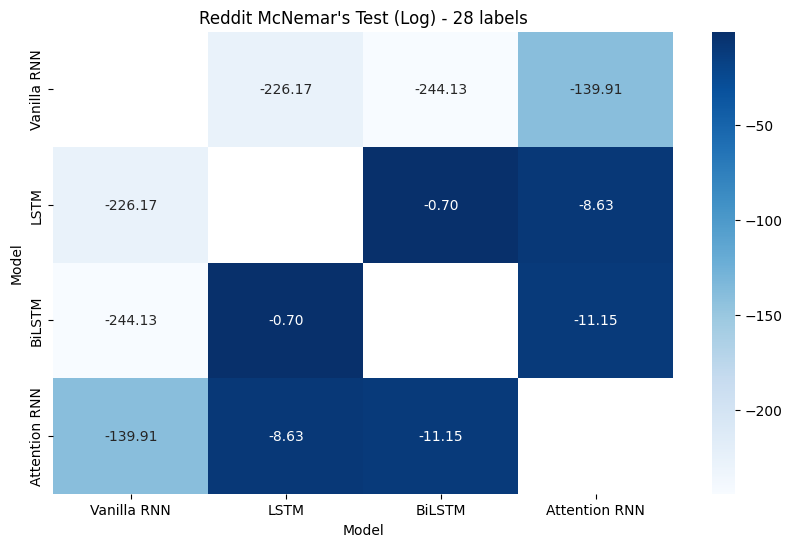

In [105]:
plt.figure(figsize=(10, 6))
log_df_mcnemar = np.log(df_mcnemar)
sns.heatmap(log_df_mcnemar, annot=True, cmap="Blues", fmt = '.2f')
plt.title("Reddit McNemar's Test (Log) - 28 labels")
plt.xlabel("Model")
plt.ylabel("Model")
plt.show()

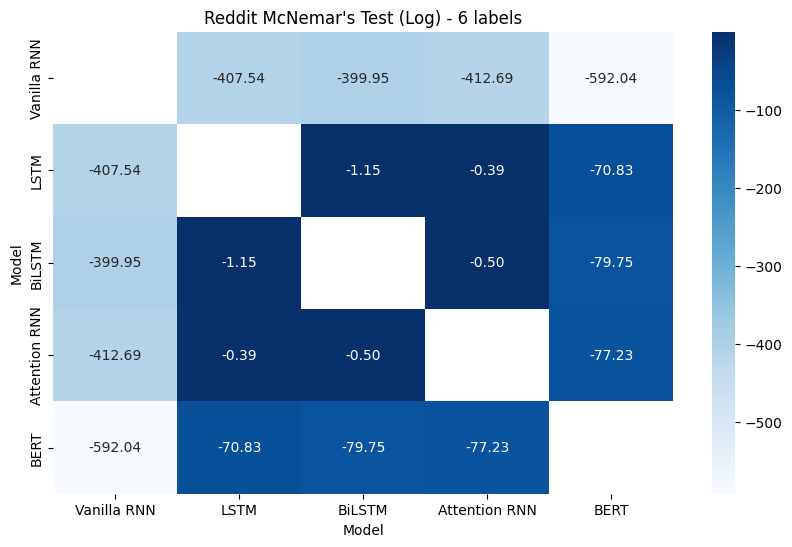

In [106]:
plt.figure(figsize=(10, 6))
log_df_mcnemar = np.log(df_mcnemar_six)
sns.heatmap(log_df_mcnemar, annot=True, cmap="Blues", fmt = '.2f')
plt.title("Reddit McNemar's Test (Log) - 6 labels")
plt.xlabel("Model")
plt.ylabel("Model")
plt.show()

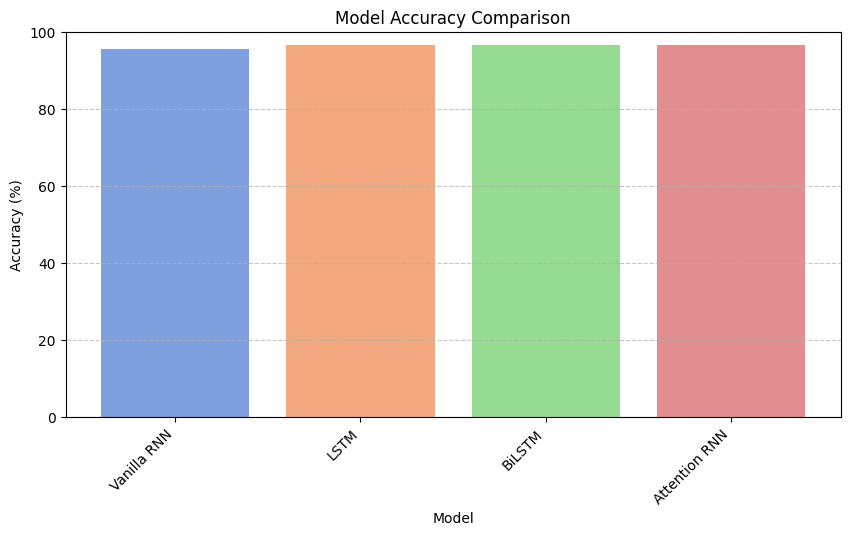

In [107]:
# accuracy bar chart
models = df_test_results.index

# Extract metric values
accuracy_values = df_test_results["Accuracy (%)"].values
f1_values = df_test_results["F1-Score"].values * 100

x = np.arange(len(models))

palette = sns.color_palette("muted", len(models))


plt.figure(figsize=(10, 5))
plt.bar(models, df_test_results["Accuracy (%)"].values, color=palette, alpha=0.7)

plt.xlabel("Model")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Show plot
plt.show()



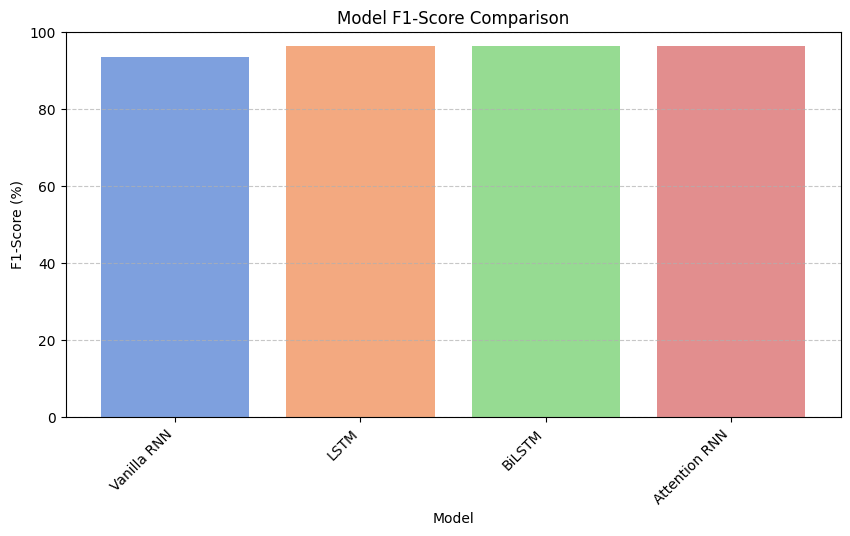

In [108]:
# f1-score bar chart

plt.figure(figsize=(10, 5))
plt.bar(models, df_test_results["F1-Score"].values * 100, color=palette, alpha=0.7)  # Scale F1-score


plt.xlabel("Model")
plt.ylabel("F1-Score (%)")
plt.title("Model F1-Score Comparison")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 100)  # Full scale for visibility
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Show plot
plt.show()


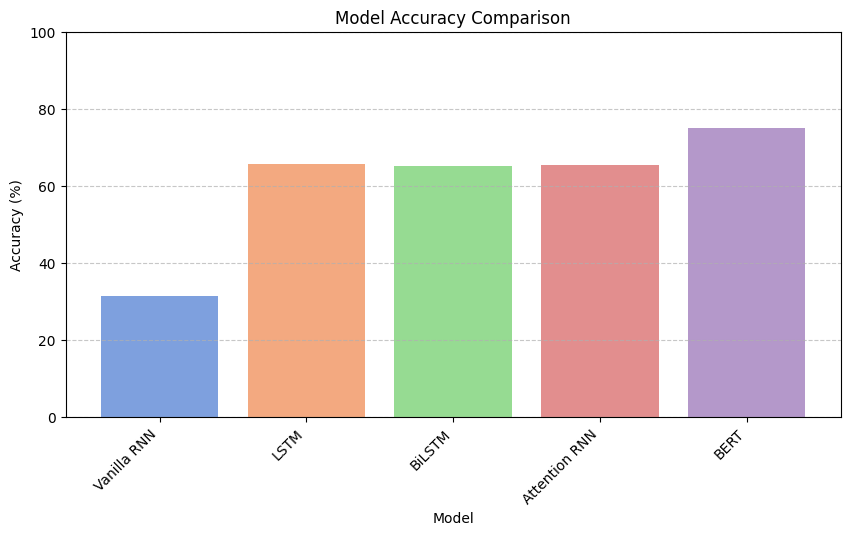

In [109]:
# accuracy bar chart for six labels
models = df_test_results_six.index

# Extract metric values
accuracy_values = df_test_results_six["Accuracy (%)"].values
f1_values = df_test_results_six["F1-Score"].values * 100

x = np.arange(len(models))

palette = sns.color_palette("muted", len(models))


plt.figure(figsize=(10, 5))
plt.bar(models, df_test_results_six["Accuracy (%)"].values, color=palette, alpha=0.7)

plt.xlabel("Model")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Show plot
plt.show()

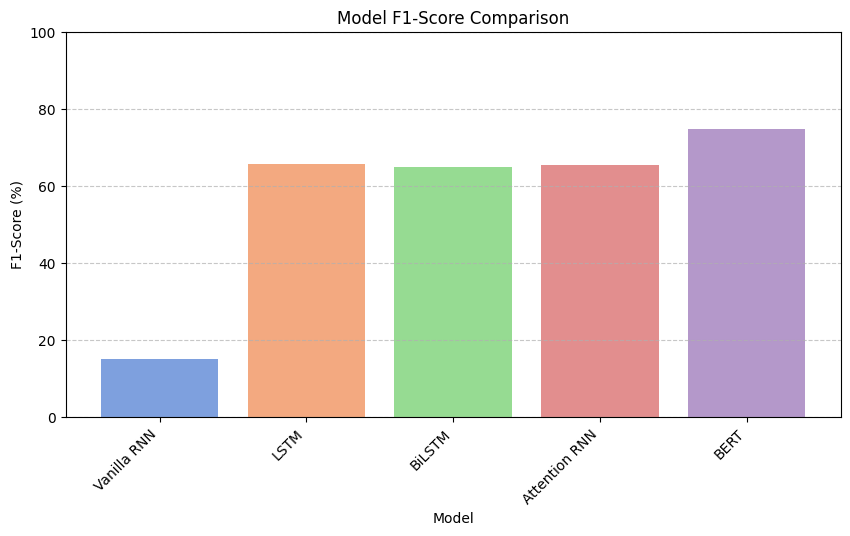

In [110]:
# f1-score bar chart for 6 labels

plt.figure(figsize=(10, 5))
plt.bar(models, df_test_results_six["F1-Score"].values * 100, color=palette, alpha=0.7)  # Scale F1-score


plt.xlabel("Model")
plt.ylabel("F1-Score (%)")
plt.title("Model F1-Score Comparison")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 100)  # Full scale for visibility
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Show plot
plt.show()

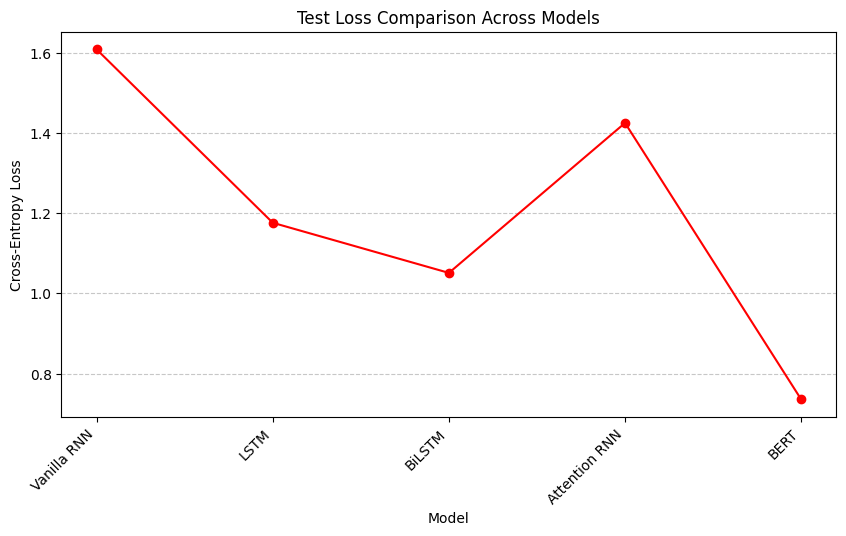

In [115]:
# Extract loss values - six labels
loss_values = df_test_results_six["Cross-Entropy Loss"].values

plt.figure(figsize=(10, 5))
plt.plot(models, loss_values, marker='o', linestyle='-', color='red')

plt.xlabel("Model")
plt.ylabel("Cross-Entropy Loss")
plt.title("Test Loss Comparison Across Models")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Show plot
plt.show()


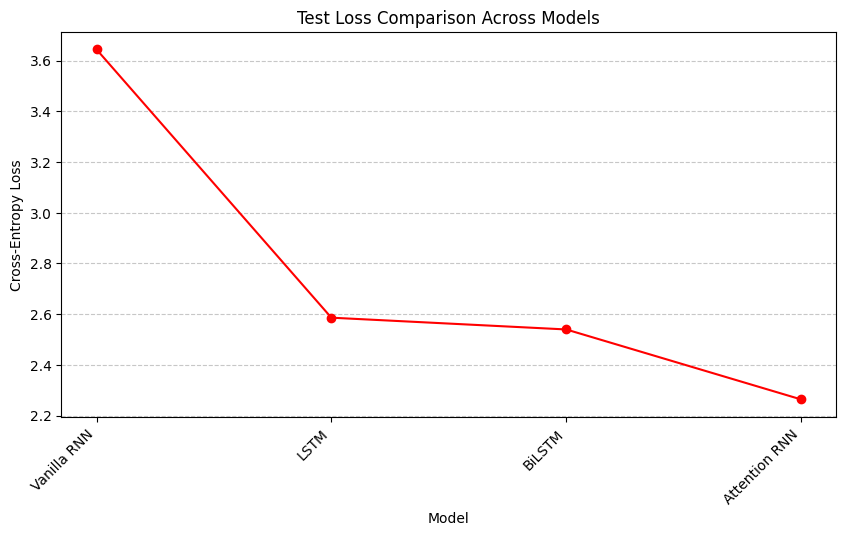

In [116]:
# Extract loss values - six labels
loss_values = df_test_results["Cross-Entropy Loss"].values

models_no_bert = models.drop("BERT")

plt.figure(figsize=(10, 5))
plt.plot(models_no_bert, loss_values, marker='o', linestyle='-', color='red')

plt.xlabel("Model")
plt.ylabel("Cross-Entropy Loss")
plt.title("Test Loss Comparison Across Models")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Show plot
plt.show()

# classification across categories

In [117]:
def map_emotions_to_category(predictions, labels, mapping, emotion_labels):

    category_predictions = {category: [] for category in mapping.keys()}
    category_labels = {category: [] for category in mapping.keys()}

    for sample_idx in range(len(predictions)):
        if predictions.ndim == 1:  # For BERT
            pred_emotions = [emotion_labels[predictions[sample_idx]]]
        else:  # For other models
            pred_emotions = [emotion_labels[i] for i in range(len(emotion_labels)) if predictions[sample_idx, i] == 1]

        if labels.ndim == 1:  # For BERT
            true_emotions = [emotion_labels[labels[sample_idx]]]
        else:  # For other models
            true_emotions = [emotion_labels[i] for i in range(len(emotion_labels)) if labels[sample_idx, i] == 1]


        for category, emotions in mapping.items():
            category_predictions[category].append(1 if any(e in emotions for e in pred_emotions) else 0)
            category_labels[category].append(1 if any(e in emotions for e in true_emotions) else 0)

    y_pred_binned = np.array([category_predictions[cat] for cat in mapping.keys()]).T
    y_true_binned = np.array([category_labels[cat] for cat in mapping.keys()]).T

    return y_pred_binned, y_true_binned

In [118]:
binned_results = {}

for model_name in trained_models.keys():
    if model_name == "BERT":
        y_pred = np.asarray(b_all_preds)
        y_true = np.asarray(b_all_labels)
    else:
        y_pred = model_predictions[model_name]
        y_true = model_labels[model_name]

    y_pred_sentiment, y_true_sentiment = map_emotions_to_category(y_pred, y_true, sentiment_mapping, emotion_labels)

    sentiment_scores = {}
    for i, category in enumerate(sentiment_mapping.keys()):
        acc = accuracy_score(y_true_sentiment[:, i], y_pred_sentiment[:, i]) * 100
        f1 = f1_score(y_true_sentiment[:, i], y_pred_sentiment[:, i], average="binary")

        sentiment_scores[category] = {"Accuracy (%)": acc, "F1-Score": f1}

    binned_results[f"{model_name} - Sentiment"] = sentiment_scores


    y_pred_ekman, y_true_ekman = map_emotions_to_category(y_pred, y_true, ekman_mapping, emotion_labels)

    ekman_scores = {}
    for i, category in enumerate(ekman_mapping.keys()):
        acc = accuracy_score(y_true_ekman[:, i], y_pred_ekman[:, i]) * 100
        f1 = f1_score(y_true_ekman[:, i], y_pred_ekman[:, i], average="binary")

        ekman_scores[category] = {"Accuracy (%)": acc, "F1-Score": f1}

    binned_results[f"{model_name} - Ekman"] = ekman_scores

In [119]:
df_binned_results = pd.DataFrame.from_dict({(i,j): binned_results[i][j]
                    for i in binned_results.keys()
                    for j in binned_results[i].keys()}, orient='index')

df_binned_results

Accuracy (%)  F1-Score
Vanilla RNN - Sentiment   positive      44.230769  0.000000
                          negative      67.032967  0.000000
                          ambiguous     82.692308  0.000000
Vanilla RNN - Ekman       anger         78.571429  0.000000
                          fear          97.445055  0.000000
                          joy           64.560440  0.000000
                          love          75.329670  0.000000
                          sadness       90.027473  0.000000
                          surprise      82.692308  0.000000
LSTM - Sentiment          positive      83.324176  0.836784
                          negative      77.719780  0.530943
                          ambiguous     86.346154  0.467310
LSTM - Ekman              anger         83.763736  0.462238
                          fear          98.296703  0.569444
                          joy           84.313187  0.743831
                          love          87.170330  0.731146
                          sadness       92.692308  0.490421
                          surprise      86.346154  0.467310
BiLSTM - Sentiment        positive      83.461538  0.838865
                          negative      76.401099  0.480339
                          ambiguous     86.153846  0.437500
BiLSTM - Ekman            anger         82.912088  0.407619
                          fear          98.241758  0.522388
                          joy           84.340659  0.750656
                          love          87.307692  0.725979
                          sadness       92.445055  0.455446
                          surprise      86.153846  0.437500
Attention RNN - Sentiment positive      82.527473  0.829764
                          negative      80.741758  0.638100
                          ambiguous     86.428571  0.553345
Attention RNN - Ekman     anger         85.769231  0.590837
                          fear          98.516484  0.670732
                          joy           83.846154  0.748503
                          love          86.950549  0.712296
                          sadness       92.884615  0.528233
                          surprise      86.428571  0.553345

In [120]:
df_sentiment = df_binned_results.loc[df_binned_results.index.get_level_values(0).str.contains("Sentiment")]
df_ekman = df_binned_results.loc[df_binned_results.index.get_level_values(0).str.contains("Ekman")]

df_sentiment = df_sentiment.reset_index().rename(columns={"level_0": "Model", "level_1": "Category"})
df_ekman = df_ekman.reset_index().rename(columns={"level_0": "Model", "level_1": "Category"})

<ipython-input-121-8e345e106dae>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_sentiment, x="Model", y="Accuracy (%)", hue="Category", ci=None)


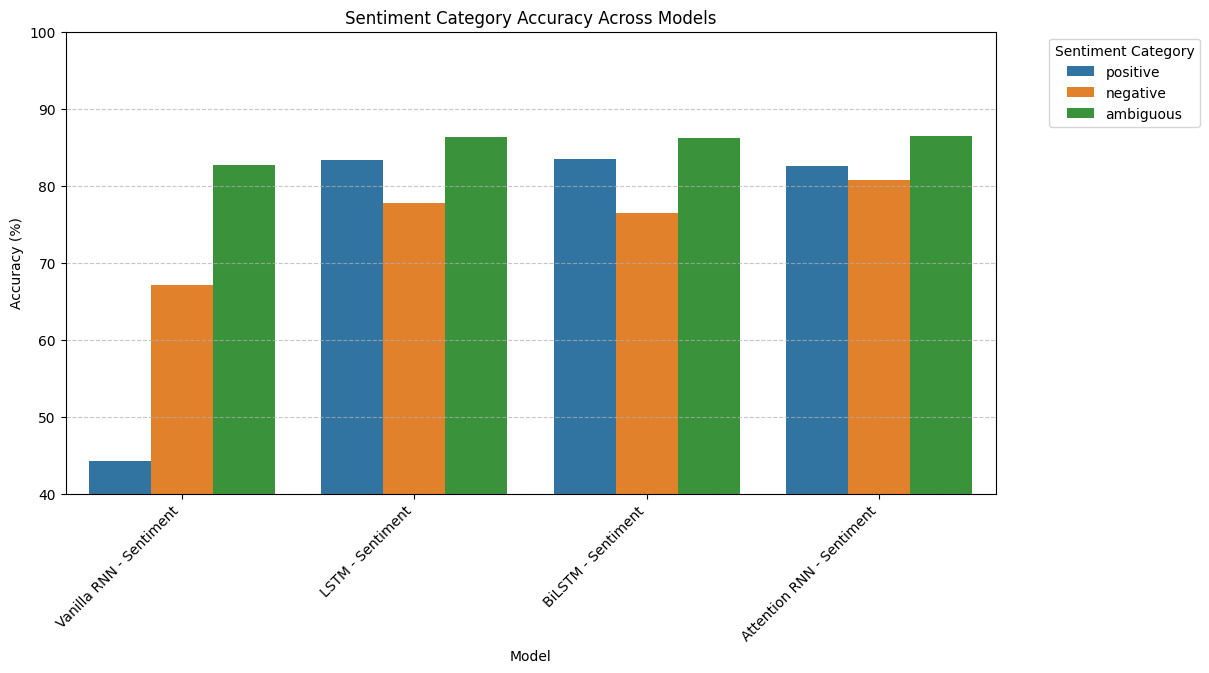

In [121]:
plt.figure(figsize=(12, 6))

# Use seaborn to create a grouped bar chart
sns.barplot(data=df_sentiment, x="Model", y="Accuracy (%)", hue="Category", ci=None)

plt.xlabel("Model")
plt.ylabel("Accuracy (%)")
plt.title("Sentiment Category Accuracy Across Models")
plt.xticks(rotation=45, ha="right")
plt.ylim(40, 100)
plt.legend(title="Sentiment Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


<ipython-input-122-008a5230c442>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_ekman, x="Model", y="Accuracy (%)", hue="Category", ci=None)


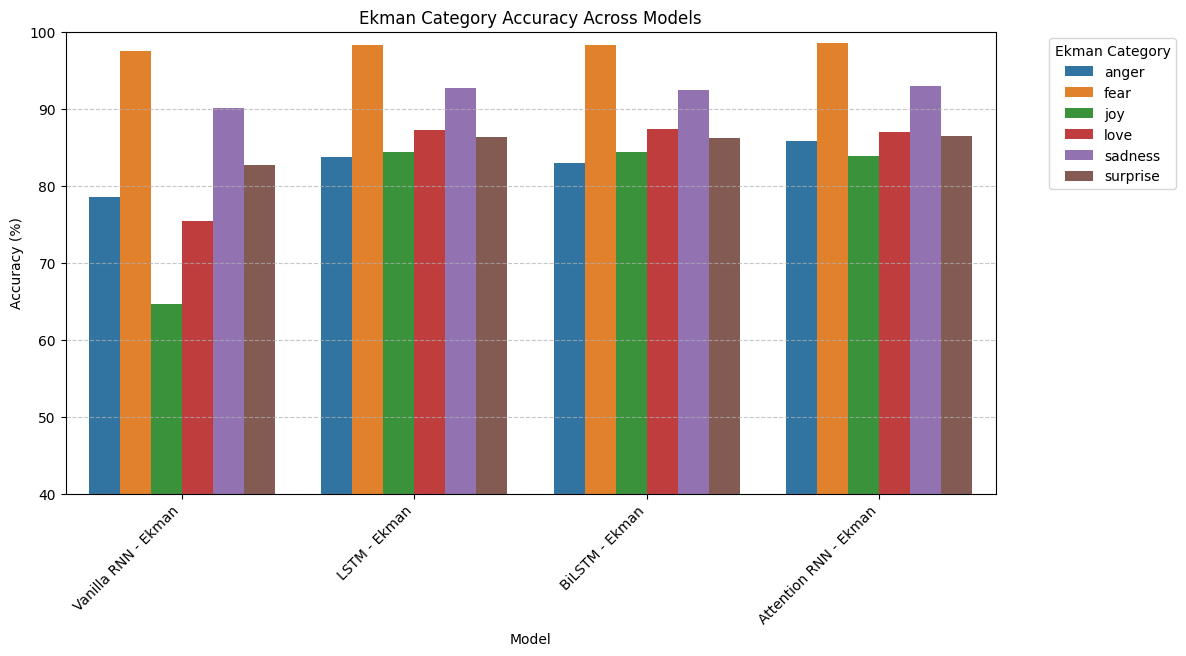

In [122]:
plt.figure(figsize=(12, 6))

# Use seaborn to create a grouped bar chart
sns.barplot(data=df_ekman, x="Model", y="Accuracy (%)", hue="Category", ci=None)

plt.xlabel("Model")
plt.ylabel("Accuracy (%)")
plt.title("Ekman Category Accuracy Across Models")
plt.xticks(rotation=45, ha="right")
plt.ylim(40, 100)
plt.legend(title="Ekman Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


In [125]:
# plot correct classifications per model for six labels

class_names = ["sadness", "joy", "love", "anger", "fear", "surprise"]

# dictionary to store per-emotion accuracy
per_emotion_accuracy = {}

for name, model in trained_models_six.items():
    all_preds, all_labels = [], []

    with torch.no_grad():
        if name == "BERT":  # Special handling for BERT
            for batch in red_bert_test_loader:
                inputs, labels = batch['input_ids'].to(device), batch['labels'].to(device)
                outputs = model(input_ids=inputs, attention_mask=(inputs > 0).long())
                preds = outputs.logits.argmax(dim=1).cpu().numpy()
                labels = labels.cpu().numpy()

                all_preds.extend(preds)
                all_labels.extend(labels)
        else:  # Handling for other models
            for batch in red_six_test_loader:
                inputs, labels = batch[0].to(device), batch[1].to(device)

                batch_size = inputs.size(0)
                hidden = model.init_hidden(batch_size)

                hidden = detach_hidden(hidden)

                preds = torch.argmax(model(inputs, hidden)[0], dim=1).cpu().numpy()
                labels = labels.cpu().numpy()

                all_preds.extend(preds)
                all_labels.extend(labels)

    conf_matrix = confusion_matrix(all_labels, all_preds)
    emotion_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1) * 100
    per_emotion_accuracy[name] = dict(zip(class_names, emotion_accuracy))

df_per_emotion_accuracy = pd.DataFrame(per_emotion_accuracy).T

In [126]:
df_per_emotion_accuracy

,sadness,joy,love,anger,fear,surprise
Vanilla RNN,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000
LSTM,49.498328,70.884956,73.067633,65.223275,50.588235,55.876686
BiLSTM,47.491639,71.592920,73.429952,63.193505,40.000000,54.720617
Attention RNN,49.498328,72.920354,69.927536,64.005413,51.764706,55.876686
BERT,54.966887,76.774759,83.909416,74.396783,69.411765,70.398482


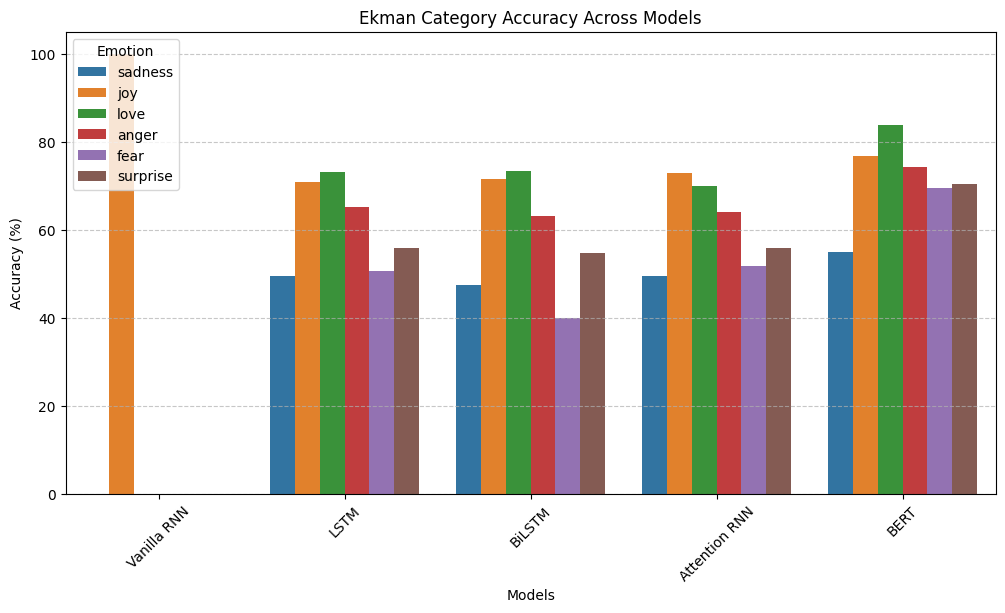

In [127]:
import seaborn as sns

df_long = df_per_emotion_accuracy.reset_index().melt(id_vars="index", var_name="Emotion", value_name="Accuracy")
df_long.rename(columns={"index": "Model"}, inplace=True)

plt.figure(figsize=(12, 6))

sns.barplot(data=df_long, x="Model", y="Accuracy", hue="Emotion")

plt.xlabel("Models")
plt.ylabel("Accuracy (%)")
plt.title("Ekman Category Accuracy Across Models")
plt.xticks(rotation=45)
plt.legend(title="Emotion")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()


<ipython-input-128-ea8c308a3f3d>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(subset["Model"], rotation=45, ha="right")
<ipython-input-128-ea8c308a3f3d>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(subset["Model"], rotation=45, ha="right")
<ipython-input-128-ea8c308a3f3d>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(subset["Model"], rotation=45, ha="right")
<ipython-input-128-ea8c308a3f3d>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(subset["Model"], rotation=45, ha="right")
<ipython-input-128-ea8c308a3f3d>:11: UserWarning: set_ticklabels() s

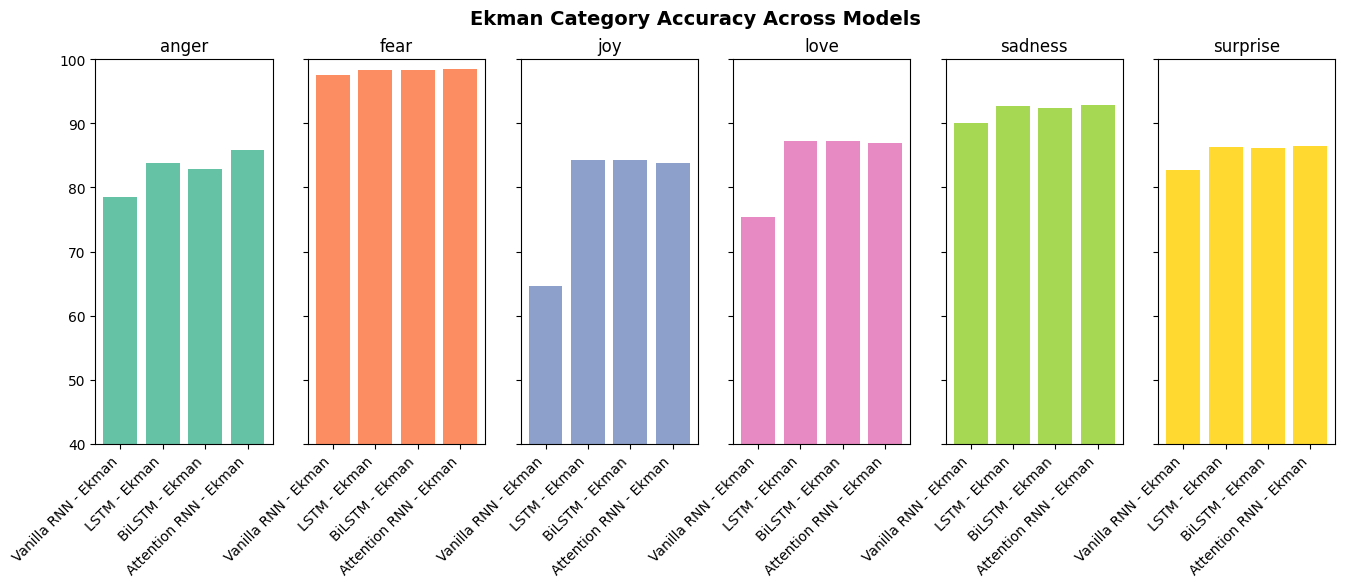

In [128]:
ekman_categories = df_ekman["Category"].unique()
num_categories = len(ekman_categories)

fig, axes = plt.subplots(1, num_categories, figsize=(16, 5), sharey=True)

for i, category in enumerate(ekman_categories):
    subset = df_ekman[df_ekman["Category"] == category]
    axes[i].bar(subset["Model"], subset["Accuracy (%)"], color=plt.cm.Set2(i))
    axes[i].set_title(category)
    axes[i].set_ylim(40, 100)
    axes[i].set_xticklabels(subset["Model"], rotation=45, ha="right")

fig.suptitle("Ekman Category Accuracy Across Models", fontsize=14, fontweight="bold")
plt.show()


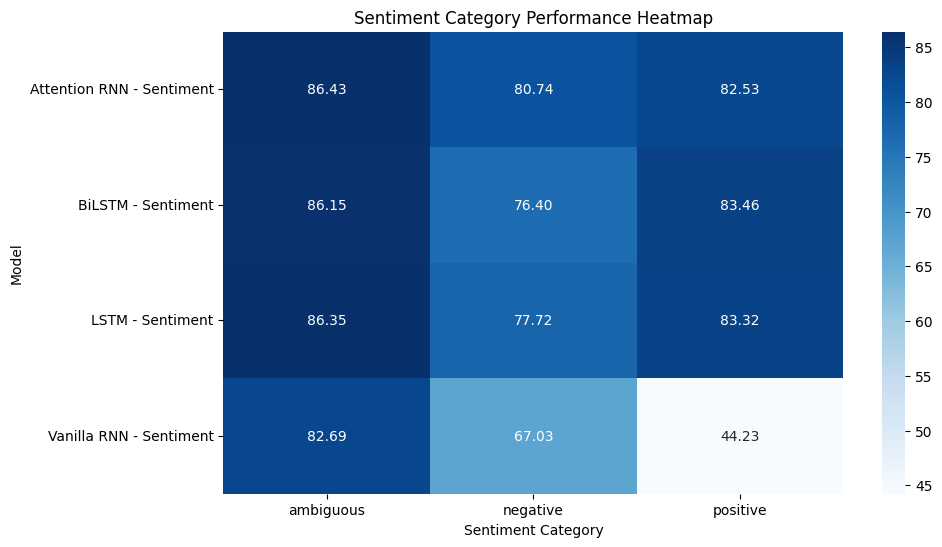

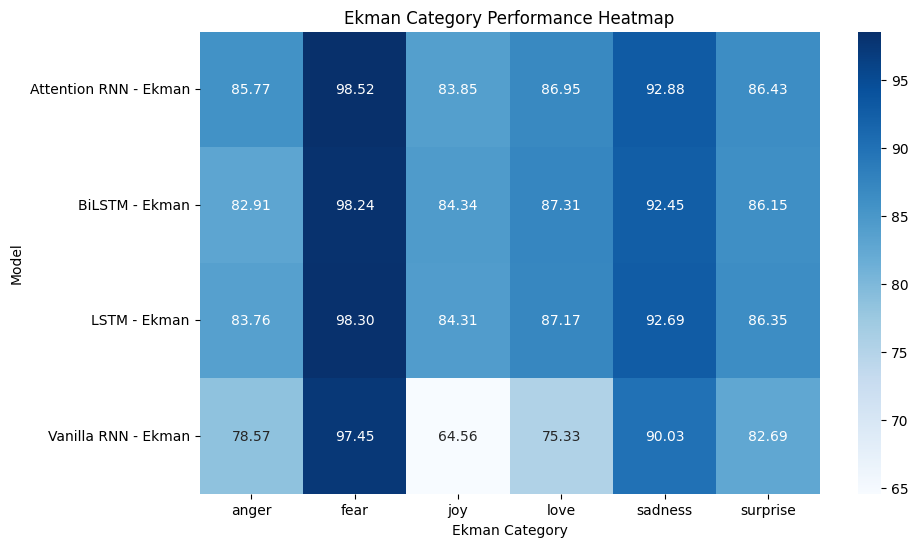

In [129]:
# Convert DataFrames to heatmap format
df_sentiment_heatmap = df_sentiment.pivot(index="Model", columns="Category", values="Accuracy (%)")
df_ekman_heatmap = df_ekman.pivot(index="Model", columns="Category", values="Accuracy (%)")

plt.figure(figsize=(10, 6))
sns.heatmap(df_sentiment_heatmap, annot=True, cmap="Blues", fmt=".2f")
plt.title("Sentiment Category Performance Heatmap")
plt.xlabel("Sentiment Category")
plt.ylabel("Model")
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(df_ekman_heatmap, annot=True, cmap="Blues", fmt=".2f")
plt.title("Ekman Category Performance Heatmap")
plt.xlabel("Ekman Category")
plt.ylabel("Model")
plt.show()


Between Dataset Classification

In [130]:
def twt_text_to_sequence(text):
    return [red_train_vocab.get(word, 0) for word in preprocess_text(text)]

twt_test = pd.read_csv(DATA_DIR + 'TWT_Test.csv')

#preprocess
twt_test_vocab = build_vocab(twt_test)

twt_test_list = [word for sentence in twt_test['text'] for word in preprocess_text(sentence)]
twt_test_count = Counter(twt_test_list)
twt_test_vocab = {word: i + 1 for i, (word, _) in enumerate(twt_test_count.most_common())}
twt_test_vocab_size = len(twt_test_vocab) + 1

twt_test['sequence'] = twt_test['text'].apply(twt_text_to_sequence)

twt_test_max_len = max(len(seq) for seq in twt_test['sequence'])
twt_test['padded_sequence'] = twt_test['sequence'].apply(lambda seq: seq + [0] * (twt_test_max_len - len(seq)))
twt_test_X = np.array(twt_test['padded_sequence'].tolist())
twt_test_y = np.array(twt_test['label'])


In [131]:
twt_test_dataset = EmotionDataset(twt_test_X, twt_test_y)
twt_test_loader = DataLoader(twt_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [132]:
#for bert

twt_test_encodings = bert_tokenizer(list(twt_test["text"]), truncation=True, padding=True, max_length=256)

# Convert labels to tensor
twt_test_labels = torch.tensor(twt_test["label"].values)

# Create PyTorch Dataset
class BertTwitterDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

twt_bert_test_dataset = BertTwitterDataset(twt_test_encodings, twt_test_labels)

# Create DataLoader
twt_bert_test_loader = DataLoader(twt_bert_test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [133]:
#evaluation on twitter dataset:

def evaluate_models(models_dict, bert_model, test_loader_rnn, test_loader_bert, device="cuda"):
    results_dict = {}
    criterion = torch.nn.CrossEntropyLoss()

    # Evaluate RNN-based models
    for model_name, model in models_dict.items():
        if model_name == "BERT":
            continue

        model.to(device)
        model.eval()
        all_preds, all_labels = [], []
        total_loss = 0
        num_batches = 0

        with torch.no_grad():
            for batch in test_loader_rnn:
                inputs, labels = batch[0].to(device), batch[1].to(device)

                batch_size = inputs.size(0)
                hidden = model.init_hidden(batch_size)

                hidden = detach_hidden(hidden)

                outputs, hidden = model(inputs, hidden)

                loss = F.cross_entropy(outputs, labels)
                total_loss += loss.item()
                num_batches += 1

                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                labels = labels.cpu().numpy()

                all_preds.extend(preds)
                all_labels.extend(labels)

        accuracy = accuracy_score(all_labels, all_preds) * 100
        f1 = f1_score(all_labels, all_preds, average="weighted")
        avg_loss = total_loss / num_batches

        results_dict[model_name] = {"Accuracy (%)": accuracy, "F1-Score": f1, "Loss": avg_loss}

    # Evaluate BERT model
    bert_model.to(device)
    bert_model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    num_batches = 0

    with torch.no_grad():
        for batch in test_loader_bert:
            inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
            labels = batch["labels"].to(device)

            outputs = bert_model(**inputs)
            logits = outputs.logits

            loss = criterion(logits, labels)
            total_loss += loss.item()
            num_batches += 1

            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels = labels.cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)

    accuracy = accuracy_score(all_labels, all_preds) * 100
    f1 = f1_score(all_labels, all_preds, average="weighted")
    avg_loss = total_loss / num_batches

    results_dict["BERT"] = {"Accuracy (%)": accuracy, "F1-Score": f1, "Loss": avg_loss}

    df_results = pd.DataFrame(results_dict).T
    return df_results


In [135]:
#redefine trained_models
trained_models = {
    "Vanilla RNN": red_six_vanilla,
    "LSTM": red_six_lstm,
    "BiLSTM": red_six_bilstm,
    "Attention RNN": red_six_attention,
    "BERT": bert_model
}

In [ ]:
# path = "/content/drive/MyDrive/NLPFinal/red_six_lstm.pth"  # Use any of your saved models
# state_dict = torch.load(path, map_location=torch.device("cpu"))

# # Print all keys inside the state_dict
# print("Keys in state_dict:", state_dict.keys())
# new_state_dict = {k.replace("rnn", "lstm"): v for k, v in state_dict.items()}

Keys in state_dict: odict_keys(['embedding.weight', 'rnn.weight_ih_l0', 'rnn.weight_hh_l0', 'rnn.bias_ih_l0', 'rnn.bias_hh_l0', 'fc.weight', 'fc.bias'])


<ipython-input-112-74df2e1fcb67>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=torch.device("cpu"))


In [136]:
# Evaluate all models (RNNs & BERT) and store results in a DataFrame
df_reddit_to_twitter_results = evaluate_models(
    trained_models,
    bert_model,
    twt_test_loader,
    twt_bert_test_loader,
    device="cuda" if torch.cuda.is_available() else "cpu"
)


df_reddit_to_twitter_results

,Accuracy (%),F1-Score,Loss
Vanilla RNN,34.70,0.179039,2.050067
LSTM,33.95,0.360085,2.439900
BiLSTM,36.30,0.374512,2.022336
Attention RNN,37.65,0.391517,3.010355
BERT,62.90,0.647614,1.106100


In [137]:
df_reddit_six_results = evaluate_models(
    trained_models,
    bert_model,
    red_six_test_loader,
    red_bert_test_loader,
    device="cuda" if torch.cuda.is_available() else "cpu"
)

df_reddit_six_results

,Accuracy (%),F1-Score,Loss
Vanilla RNN,31.388889,0.149977,1.608041
LSTM,65.805556,0.657033,1.175998
BiLSTM,65.111111,0.648671,1.051087
Attention RNN,65.500000,0.653512,1.424768
BERT,75.027473,0.748646,0.735832


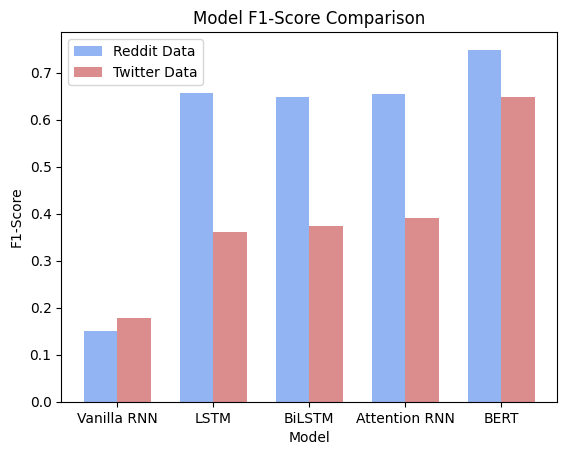

In [138]:
models = trained_models.keys()
pos = np.arange(len(df_reddit_six_results['F1-Score']))
width = 0.35

# Plotting the bars
fig, ax = plt.subplots()
bar1 = ax.bar(pos - width/2, df_reddit_six_results['F1-Score'], width, color="cornflowerblue", alpha=0.7, label = "Reddit Data")
bar2 = ax.bar(pos + width/2, df_reddit_to_twitter_results['F1-Score'], width, color="indianred", alpha=0.7, label = "Twitter Data")

# Adding labels and title
ax.set_xticks(pos)
ax.set_xticklabels(models)
ax.set_title("Model F1-Score Comparison")
ax.set_xlabel("Model")
ax.set_ylabel("F1-Score")
ax.legend()
plt.show()


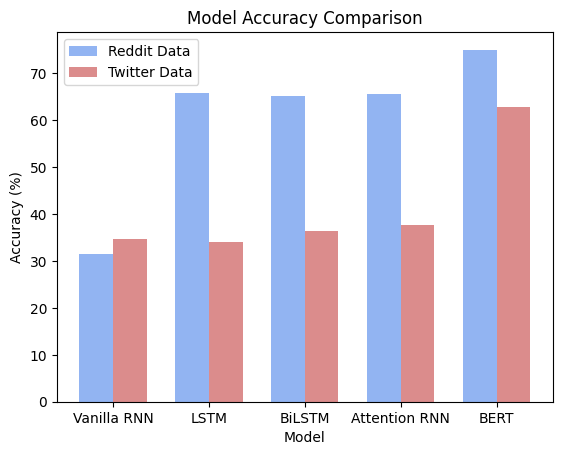

In [139]:
# Plotting the bars
fig, ax = plt.subplots()
bar1 = ax.bar(pos - width/2, df_reddit_six_results['Accuracy (%)'], width, color="cornflowerblue", alpha=0.7, label = "Reddit Data")
bar2 = ax.bar(pos + width/2, df_reddit_to_twitter_results['Accuracy (%)'], width, color="indianred", alpha=0.7, label = "Twitter Data")

# Adding labels and title
ax.set_xticks(pos)
ax.set_xticklabels(models)
ax.set_title("Model Accuracy Comparison")
ax.set_xlabel("Model")
ax.set_ylabel("Accuracy (%)")
ax.legend()
plt.show()


In [140]:
#statistical significance

from scipy.stats import ttest_rel

accuracy_twitter = df_reddit_to_twitter_results["Accuracy (%)"].values
accuracy_reddit = df_reddit_six_results["Accuracy (%)"].values

t_stat, p_value = ttest_rel(accuracy_twitter, accuracy_reddit)

print(f"Paired t-test Results: t-statistic = {t_stat:.5f}, p-value = {p_value:.5f}")

if p_value < 0.05:
    print("The accuracy difference between Twitter and Reddit is statistically significant.")
else:
    print("No significant difference in accuracy between Twitter and Reddit.")


Paired t-test Results: t-statistic = -2.92843, p-value = 0.04288
The accuracy difference between Twitter and Reddit is statistically significant.
